In [1]:
from pandasql import sqldf
import pandas as pd
import pandasql
pysqldf = lambda q: sqldf(q, globals())

In [2]:
#upload encounter level dataset
#filename = 'encounter_level_comp.csv'
s_data = pd.DataFrame.from_csv('encounter_level_comp.csv', index_col=None)
s_data.columns

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


Index(['Unnamed: 0', 'patient_id', 'encounter_id', 'minday', 'maxday',
       'minseason', 'maxseason', 'loc_cat', 'maxIVF_meds', 'countIVF_meds',
       ...
       'avgo2sat_c', 'avgplatelet_count_c', 'minplatelet_count_c', 'avgppi_c',
       'avgrr_c', 'avgsbp_c', 'avgsgot_c', 'avgsodium_c', 'avgwbc_c',
       'minwbc_c'],
      dtype='object', length=445)

In [3]:
s_data = s_data.drop(s_data.columns[0], axis=1)
#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
s_data.head()
#s_data.info()

,patient_id,encounter_id,minday,maxday,minseason,maxseason,loc_cat,maxIVF_meds,countIVF_meds,maxIVF_volume,...,avgo2sat_c,avgplatelet_count_c,minplatelet_count_c,avgppi_c,avgrr_c,avgsbp_c,avgsgot_c,avgsodium_c,avgwbc_c,minwbc_c
0,4158,2304401,718.0,722.0,1,1,71,NaN,0,NaN,...,95.013699,167.488584,139.0,0.524223,19.917808,120.260274,28.000000,135.780822,5.904110,3.5
1,8540,2663486,632.0,715.0,1,1,221,100.0,6,NaN,...,98.293333,317.595556,211.0,0.428101,17.151111,132.099259,25.586667,140.697778,9.725778,8.0
2,12547,2507891,633.0,643.0,1,1,247,100.0,2,NaN,...,96.562249,179.315930,145.0,0.465975,19.048193,135.258367,22.626506,136.417671,11.297189,5.9
3,15765,2360133,575.0,631.0,1,1,54,NaN,0,NaN,...,97.517857,254.750000,211.0,0.397416,28.160714,117.750000,40.285714,136.464286,10.960714,8.1
4,15765,2365036,570.0,576.0,1,1,50,NaN,0,NaN,...,95.557692,236.250000,188.0,0.368264,21.250000,116.923077,28.000000,137.480769,12.313462,8.1


In [ ]:
#s_data['maxinfxnqsofa'].count()

In [4]:
q  = """
SELECT *
FROM s_data
WHERE maxinfxnqsofa = 1;
"""
sep = pysqldf(q)
#find all septic encounters
#we do not need to require that we look at one septic encounter per patient
#but we will need a variable that details out how many septic encounters that person has experienced

In [ ]:
#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
#sep.describe()

In [5]:
#all septic encounters to csv to be used in other notebooks
sep.to_csv('sep.csv')

In [6]:
sep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Columns: 444 entries, patient_id to minwbc_c
dtypes: float64(339), int64(56), object(49)
memory usage: 1.3+ MB


The following sql command is looking for all variables from the septic encounter, and the next readmission to the icu/er. We will not need all information for readmission that we will need for the encounter or prior encounters, just the target variables. If we were looking at more than one readmission we would include the full set of variables included in the readmission encounter, for purposes of time and making this the first iteration we will only include the first readmission and when the readmission happened, and if they died. If we want to later predict the risk of mortality at readmision for these patients we will add in all the variables again and reference CAPSTONE_PANDASQL(PATIENT_LEVEL)READMISSION

All remaining variables are added for dq checks on EDA and will be removed for final dataset for ML ALGS

In [7]:
#Readmission variables to test
f  = """
SELECT sep.patient_id,
sep.encounter_id,
s_data.maxday - sep.minday as day_to_read,
s_data.encounter_id as encounter_id1,
s_data.maxday as maxday1,
s_data.minseason as minseason1, s_data.maxseason as maxseason1,  
s_data.concatdischarge_dispo as concatdischarge_dispo1, 

s_data.maxadmission_order as maxadmission_order1,
s_data.maxtransfer_order as maxtransfer_order1,
s_data.concatreason as concatreason1,
s_data.maxtreatment_limit as maxtreatment_limit1,
s_data.maxwardorICU as maxwardorICU1,
s_data.maxeverwardorICU as maxeverwardorICU1, 
s_data.maxexpired as maxexpired1, 
s_data.maxdied01 as maxdied011, 
s_data.maxdied_ever as maxdied_ever1,
s_data.maxage as maxage1, 
s_data.maxicu_flag as maxicu_flag1,
s_data.maxnum_icustays as maxnum_icustays1
FROM sep
LEFT JOIN s_data USING(patient_id)
WHERE sep.maxday < s_data.minday AND sep.encounter_id != s_data.encounter_id;
"""

read1_test = pysqldf(f)
read1_test.head()

,patient_id,encounter_id,day_to_read,encounter_id1,maxday1,minseason1,maxseason1,concatdischarge_dispo1,maxadmission_order1,maxtransfer_order1,concatreason1,maxtreatment_limit1,maxwardorICU1,maxeverwardorICU1,maxexpired1,maxdied011,maxdied_ever1,maxage1,maxicu_flag1,maxnum_icustays1
0,72671,2667646,87.0,2611657,759.0,1,1,"Home LW,Home LW,Home LW,Home LW,Home LW,Home L...",None,None,None,None,1.0,1.0,NaN,0.0,0.0,48,NaN,0
1,72716,2325650,59.0,2304041,440.0,1,1,"Home Health Care, Home LW,Home Health Care, Ho...",None,None,None,None,1.0,1.0,NaN,0.0,0.0,33,NaN,0
2,79762,2613734,30.0,2509686,783.0,1,1,"Discharged to a SNF, Home LW,Discharged to a S...",None,None,None,None,1.0,1.0,NaN,0.0,0.0,64,NaN,0
3,142116,2292231,158.0,2309187,538.0,1,1,"Home Health Care, Home LW,Home Health Care, Ho...",None,None,None,None,1.0,1.0,NaN,0.0,0.0,46,1.0,1
4,147928,2561058,133.0,2548187,835.0,1,1,"Discharged to another Hospital, Discharged/Tra...",None,None,None,None,1.0,1.0,NaN,0.0,0.0,67,1.0,1


In [8]:
#readmission 
w  = """
SELECT sep.patient_id,
sep.encounter_id,
s_data.maxday - sep.minday as day_to_read,
sep.maxday,
s_data.encounter_id as encounter_id1,
s_data.minseason as minseason1
FROM sep
LEFT JOIN s_data USING(patient_id)
WHERE sep.maxday < s_data.minday AND sep.encounter_id != s_data.encounter_id;
"""
#see if seasonal variable comes into play-- does the patient's chance of readmission increase depending on season?
read1 = pysqldf(w)
read1.head()

,patient_id,encounter_id,day_to_read,maxday,encounter_id1,minseason1
0,72671,2667646,87.0,696.0,2611657,1
1,72716,2325650,59.0,387.0,2304041,1
2,79762,2613734,30.0,759.0,2509686,1
3,142116,2292231,158.0,523.0,2309187,1
4,147928,2561058,133.0,772.0,2548187,1


In [9]:
read1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 6 columns):
patient_id       33 non-null int64
encounter_id     33 non-null int64
day_to_read      33 non-null float64
maxday           33 non-null float64
encounter_id1    33 non-null int64
minseason1       33 non-null int64
dtypes: float64(2), int64(4)
memory usage: 1.6 KB


In [10]:
read1.to_csv('read1.csv')

In [11]:
read1.head(10)
#note that we will most likely have to remove multiple readmissions

,patient_id,encounter_id,day_to_read,maxday,encounter_id1,minseason1
0,72671,2667646,87.0,696.0,2611657,1
1,72716,2325650,59.0,387.0,2304041,1
2,79762,2613734,30.0,759.0,2509686,1
3,142116,2292231,158.0,523.0,2309187,1
4,147928,2561058,133.0,772.0,2548187,1
5,147928,2561058,89.0,772.0,2614666,1
6,147928,2614666,53.0,791.0,2548187,1
7,152378,2550586,79.0,394.0,2324203,1
8,171540,2576881,14.0,562.0,2322717,1
9,171540,2576881,36.0,562.0,2579545,1


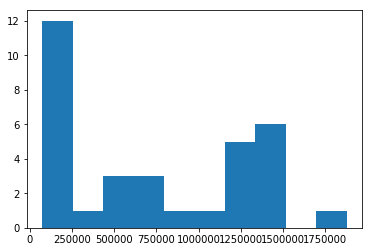

In [12]:
import matplotlib.pyplot as plt
plt.hist(read1.patient_id)
plt.show()

In [13]:
import pandas as pd
import numpy
read1['patient_id'].count()

33

In [14]:
sep.describe()

,patient_id,encounter_id,minday,maxday,minseason,maxseason,loc_cat,maxIVF_meds,countIVF_meds,maxfio2,...,avgo2sat_c,avgplatelet_count_c,minplatelet_count_c,avgppi_c,avgrr_c,avgsbp_c,avgsgot_c,avgsodium_c,avgwbc_c,minwbc_c
count,3.730000e+02,3.730000e+02,373.000000,373.000000,373.0,373.0,373.000000,279.000000,373.000000,67.000000,...,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,9.642788e+05,2.400243e+06,549.855228,572.512064,1.0,1.0,275.879357,429.936201,24.410188,73.895522,...,97.306103,245.153478,163.896336,0.433089,19.418725,124.941012,59.035225,138.474628,10.701495,6.084719
std,6.383691e+05,1.319164e+05,118.150967,121.338294,0.0,0.0,419.887170,3045.132828,54.865923,29.449049,...,1.430180,117.554669,63.978678,0.064164,1.774132,16.456027,386.176854,3.436049,12.059813,3.493367
min,4.158000e+03,1.867781e+06,342.000000,344.000000,1.0,1.0,21.000000,25.000000,0.000000,2.000000,...,89.664634,13.320513,3.000000,0.218638,15.328947,79.413363,11.037313,127.602410,1.265169,0.200000
25%,3.136920e+05,2.304041e+06,451.000000,470.000000,1.0,1.0,85.000000,100.000000,0.000000,40.000000,...,96.641434,170.188450,129.000000,0.391014,18.402145,113.276667,22.837624,136.600000,6.944521,4.400000
50%,1.025117e+06,2.353769e+06,547.000000,565.000000,1.0,1.0,158.000000,250.000000,8.000000,100.000000,...,97.538647,230.677321,196.000000,0.431054,19.160494,123.893102,28.000000,138.645833,9.055307,6.400000
75%,1.466868e+06,2.520285e+06,646.000000,664.000000,1.0,1.0,275.000000,250.000000,24.000000,100.000000,...,98.284314,305.976776,211.000000,0.474299,20.000000,135.818713,35.837302,140.479452,11.823392,8.100000
max,1.929412e+06,2.668016e+06,849.000000,1012.000000,1.0,1.0,3429.000000,51000.000000,434.000000,100.000000,...,99.887097,784.909605,519.000000,0.665835,29.079545,179.890295,7412.180039,155.812500,202.096826,58.000000


In [16]:
sepsub = sep[['patient_id','encounter_id', 'minday', 'maxday']]

In [17]:
#prior encounter at icu/er
#all variables not below dependent upon encounter time
f  = """
SELECT sepsub.*, 
s_data.encounter_id as encounter_id_p1, 
s_data.minday as minday_p1, s_data.maxday as maxday_p1,
s_data.minseason as minseason_p1, s_data.maxseason as maxseason_p1,
s_data.loc_cat as loc_cat_p1, 
s_data.maxIVF_meds as maxIVF_meds_p1, s_data.countIVF_meds as countIVF_meds_p1, 
s_data.maxIVF_volume as maxIVF_volume_p1, s_data.avgIVF_volume as avgIVF_volume_p1, 
s_data.maxIV_intake as maxIV_intake_p1,
s_data.maxfio2 as maxfio2_p1, s_data.avgfio2 as avgfio2_p1, 
s_data.maxfio2_vent as maxfio2_vent1, s_data.avgfio2_vent as avgfio2_vent_p1, 
s_data.maxgastric_output as maxgastric_output_p1, s_data.mingastric_output as mingastric_output_p1, s_data.avggastric_output as avggastric_output_p1, 
s_data.maxgcs_eye as maxgcs_eye_p1, s_data.mingcs_eye as mingcs_eye_p1, 
s_data.maxgcs_motor as maxgcs_motor_p1, s_data.mingcs_motor as mingcs_motor_p1, 
s_data.maxgcs_score as maxgcs_score_p1, s_data.avggcs_score as avggcs_score_p1, 
s_data.maxgcs_verbal as maxgcs_verbal_p1, s_data.mingcs_verbal as mingcs_verbal_p1, 
s_data.maxhfo_fio2 as maxhfo_fio2_p1, s_data.avghfo_fio2 as avghfo_fio2_p1, 
s_data.maxmap_notcalc as maxmap_notcalc_p1, s_data.minmap_notcalc as minmap_notcalc_p1, s_data.avgmap_notcalc as avgmap_notcalc_p1, 
s_data.maxmap_zzz as maxmap_zzz_p1, s_data.minmap_zzz as minmap_zzz_p1, s_data.avgmap_zzz as avgmap_zzz_p1, 
s_data.maxnasal_cannula as maxnasal_cannula_p1, 
s_data.maxni_fio2 as maxni_fio2_p1, s_data.avgni_fio2 as avgni_fio2_p1, 
s_data.maxni_vent as maxni_vent_p1, 
s_data.maxo2_device as maxo2_device_p1, 
s_data.maxo2_flow as maxo2_flow_p1, s_data.mino2_flow as mino2_flow_p1, s_data.avgo2_flow as avgo2_flow_p1, 
s_data.maxrass as maxrass_p1, s_data.minrass as minrass1, s_data.avgrass as avgrass_p1, 
s_data.maxroomair as maxroomair_p1, 
s_data.mintemp as mintemp_p1, s_data.maxtemp as maxtemp_p1, 
s_data.maxtube_output as maxtube_output_p1, s_data.avgtube_output as avgtube_output_p1, 
s_data.maxwound_output as maxwound_output_p1, s_data.avgwound_output as avgwound_output_p1, 
s_data.maxfio2_final as maxfio2_final_p1, 
s_data.maxfio2_final2 as maxfio2_final2_p1, 
s_data.maxsf_ratio_old as maxsf_ratio_old_p1, s_data.avgsf_ratio_old as avgsf_ratio_old_p1, 
s_data.maxcontam_true as maxcontam_true_p1, 
s_data.maxstaph as maxstaph_p1, 
s_data.maxabs_bands as maxabs_bands_p1, s_data.minabs_bands as minabs_bands_p1, s_data.avgabs_bands as avgabs_bands_p1, 
s_data.maxabs_neutrophils as maxabs_neutrophils_p1, s_data.maxabs_neutrophils as maxabs_neutrophil_p1, s_data.avgabs_neutrophils as avgabs_neutrophils_p1, 
s_data.maxalt as maxalt_p1, s_data.minalt as minalt1, s_data.avgalt as avgalt_p1, 
s_data.maxantitrypsin as maxantitrypsin_p1, s_data.avgantitrypsin as avgantitrypsin_p1, 
s_data.maxauto_abs_neutrophils as maxauto_abs_neutrophils_p1, s_data.minauto_abs_neutrophils as minauto_abs_neutrophils_p1, 
s_data.maxbands as maxbands_p1, s_data.minbands as minbands_p1, s_data.avgbands as avgbands_p1, 
s_data.maxbasophils as maxbasophils_p1, s_data.minbasophils as minbasophils_p1, s_data.avgbasophils as avgbasophils_p1, 
s_data.maxblasts as maxblasts_p1, s_data.minblasts as minblasts_p1, s_data.avgblasts as avgblasts_p1, 
s_data.mincdiff as mincdiff_p1, s_data.maxcdiff as maxcdiff_p1, s_data.sumcdiff as sumcdiff_p1, 
s_data.maxchloride as maxchloride_p1, s_data.minchloride as minchloride_p1, s_data.avgchloride as avgchloride_p1, 
s_data.maxcortisol as maxcortisol_p1, s_data.mincortisol as mincortisol_p1, s_data.avgcortisol as avgcortisol_p1, 
s_data.maxcrp as maxcrp_p1, s_data.mincrp as mincrp_p1, s_data.avgcrp as avgcrp_p1, 
s_data.maxcul_cathtip as maxcul_cathtip_p1, 
s_data.maxcul_csf as maxcul_csf_p1, 
s_data.maxcul_influenza as maxcul_influenza_p1, 
s_data.maxcul_mrsa as maxcul_mrsa_p1, 
s_data.maxcul_parainfluenza as maxcul_parainfluenza_p1, 
s_data.maxcul_resp as maxcul_resp_p1, 
s_data.maxeosinophils as maxeosinophils_p1, s_data.avgeosinophils as avgeosinophils_p1, 
s_data.maxesr as maxesr_p1, s_data.avgesr as avgesr_p1, 
s_data.maxhb1198 as maxhb1198_p1, s_data.avghb1198 as avghb1198_p1, 
s_data.maxhb1200 as maxhb1200_p1, s_data.avghb1200 as avghb1200_p1, 
s_data.maxhc03 as maxhc03_p1, 
s_data.maxhc03_ven as maxhc03_ven_p1, s_data.avghc03_ven as avghc03_ven_p1, 
s_data.maxhco3_art as maxhco3_art_p1, 
s_data.maxhematocrit as maxhematocrit_p1, s_data.minhematocrit as minhematocrit_p1, s_data.avghematocrit as avghematocrit_p1, 
s_data.maxinr as maxinr_p1, s_data.avginr as avginr_p1, 
s_data.maxketones as maxketones_p1, s_data.minketones as minketones_p1, s_data.avgketones as avgketones_p1, 
s_data.maxlactate1 as maxlactate1_p1, s_data.avglactate1 as avglactate1_p1, 
s_data.maxlactate_wholebld1434 as maxlactate_wholebld1434_p1, s_data.avglactate_wholebld1434 as avglactate_wholebld1434_p1, 
s_data.maxlactate_wholebld4303 as maxlactate_wholebld4303_p1, s_data.avglactate_wholebld4303 as avglactate_wholebld4303_p1, 
s_data.maxlactic_acid as maxlactic_acid_p1, s_data.minlactic_acid as minlactic_acid_p1, s_data.avglactic_acid as avglactic_acid_p1, 
s_data.maxlipase as maxlipase_p1, s_data.minlipase as minlipase_p1, s_data.lipase as avglipase_p1, 
s_data.maxlymphocytes as maxlymphocytes_p1, s_data.minlymphocytes as minlymphocytes_p1, s_data.avglymphocytes as avglymphocytes_p1, 
s_data.maxmagnesium as maxmagnesium_p1, s_data.minmagnesium as minmagnesium_p1, s_data.avgmagnesium as avgmagnesium_p1, 
s_data.maxmcv as maxmcv_p1, s_data.avgmcv as avgmcv_p1, 
s_data.maxmetamyelocytes as maxmetamyelocytes_p1, s_data.minmetamyelocytes as minmetamyelocytes_p1, s_data.avgmetamyelocytes as avgmetamyelocytes_p1, 
s_data.maxmonocytes as maxmonocytes_p1, s_data.minmonocytes as minmonocytes_p1, s_data.avgmonocytes as avgmonocytes_p1, 
s_data.maxneutrophils as maxneutrophils_p1, s_data.minneutrophils as minneutrophils_p1, s_data.avgneutrophils as avgneutrophils_p1, 
s_data.maxnrbc as maxnrbc_p1, s_data.avgnrbc as avgnrbc_p1, 
s_data.maxosmolality as maxosmolality_p1, s_data.minosmolality as minosmolality_p1, s_data.avgosmolality as avgosmolality_p1, 
s_data.maxpaco2 as maxpaco2_p1, s_data.avgpaco2 as avgpaco2_p1, 
s_data.maxpao2 as maxpao2_p1, s_data.avgpao2 as avgpao2_p1, 
s_data.maxpco2_1097 as maxpco2_1097_p1, 
s_data.maxpco2_4098 as maxpco2_4098_p1, 
s_data.maxph1250 as maxph1250_p1, s_data.avgph1250 as avgph1250_p1, 
s_data.maxph1819 as maxph1819_p1, s_data.avgph1819 as avgph1819_p1, 
s_data.maxph272 as maxph272_p1, s_data.avgph272 as avgph272_p1, 
s_data.maxph4315 as maxph4315_p1, s_data.avgph4315 as avgph4315_p1, 
s_data.maxph690 as maxph690_p1, s_data.avgph690 as avgph690_p1, 
s_data.maxphosphate as maxphosphate_p1, s_data.minphosphate as minphosphate_p1, s_data.avgphosphate as avgphosphate_p1,
s_data.maxpotassium as maxpotassium_p1, s_data.minpotassium as minpotassium_p1, s_data.avgpotassium as avgpotassium_p1, 
s_data.maxpromyelocytes as maxpromyelocytes_p1, s_data.avgpromyelocytes as avgpromyelocytes_p1, 
s_data.maxtotal_protein as maxtotal_protein_p1, s_data.avgtotal_protein as avgtotal_protein_p1, 
s_data.maxptt as maxptt_p1, s_data.minptt as minptt_p1, s_data.avgptt as avgptt_p1,
s_data.maxpvco2 as maxpvco2_p1, s_data.minpvco2 as minpvco2_p1, s_data.maxpvo2 as maxpvo2_p1,
s_data.maxpvo2 as maxpvo2_p1, s_data.minpvo2 as minpvo2_p1, s_data.maxpvo2 as maxpvo2_p1,
s_data.maxrbc as maxrbc_p1, s_data.minrbc as minrbc_p1, s_data.avgrbc as avgrbc_p1, 
s_data.maxrdw as maxrdw_p1, s_data.minrdw as minrdw_p1, s_data.avgrdw as avgrdw_p1, 
s_data.maxsvo2_2641 as maxsvo2_2641_p1, s_data.avgsvo2_2641 as avgsvo2_2641_p1, 
s_data.maxsvo2_4351 as maxsvo2_4351_p1, s_data.avgsvo2_4351 as avgsvo2_4351_p1, 
s_data.maxtroponin_old as maxtroponin_old_p1, s_data.avgtroponin_old as avgtroponin_old_p1, 
s_data.maxlactate as maxlactate_p1, s_data.avglactate as avglactate_p1, 

s_data.minenc_eio as minenc_eio_p1, s_data.countenc_eio as countenc_eio_p1,  
s_data.concatdischarge_dispo as concatdischarge_dispo_p1, 
s_data.diffbmi as diffbmi_p1, s_data.avgbmi as avgbmi_p1, 

s_data.maxadmission_order as maxadmission_order_p1,
s_data.maxct_chestabdpelviswo as maxct_chestabdpelviswo_p1,
s_data.maxct_chesupabd as maxct_chesupabd_p1,
s_data.maxsitter_order as maxsitter_order_p1, 
s_data.maxtranscryo as maxtranscryo_p1,
s_data.maxtransfer_order as maxtransfer_order_p1,
s_data.maxtransffp as maxtransffp_p1,
s_data.maxtransplts as maxtransplts_p1,
s_data.maxtransrbc as maxtransrbc_p1,
s_data.maxtransrbc_eq1 as maxtransrbc_eq1_p1, 
s_data.maxtransrbc_gt1 as maxtransrbc_gt1_p1, 
s_data.concatreason as concatreason_p1,
s_data.maxtreatment_limit as maxtreatment_limit_p1,
s_data.maxdrip_dexmedetomidine as maxdrip_dexmedetomidine_p1, s_data.avgdrip_dexmedetomidine as avgdrip_dexmedetomidine_p1, 
s_data.maxdrip_dobutamine as maxdrip_dobutamine_p1, s_data.avgdrip_dobutamine as avgdrip_dobutamine_p1, 
s_data.maxdrip_dopamine as maxdrip_dopamine_p1, s_data.avgdrip_dopamine as avgdrip_dopamine_p1, 
s_data.maxdrip_fentanyl as maxdrip_fentanyl_p1, s_data.avgdrip_fentanyl as avgdrip_fentanyl_p1, 
s_data.maxdrip_midazolam as maxdrip_midazolam_p1, s_data.avgdrip_midazolam as avgdrip_midazolam_p1, 
s_data.maxdrip_milrinone as maxdrip_milrinone_p1, s_data.avgdrip_milrinone as avgdrip_milrinone_p1, 
s_data.maxdrip_morphine as maxdrip_morphine_p1, s_data.avgdrip_morphine as avgdrip_morphine_p1, 
s_data.maxdrip_norepinephrine as maxdrip_norepinephrine_p1, s_data.avgdrip_norepinephrine as avgdrip_norepinephrine_p1, 
s_data.maxdrip_phenylephrine as maxdrip_phenylephrine_p1, s_data.avgdrip_phenylephrine as avgdrip_phenylephrine_p1, 
s_data.maxdrip_propofol as maxdrip_propofol_p1, s_data.avgdrip_propofol as avgdrip_propofol_p1, 
s_data.maxdrip_vasopressin as maxdrip_vasopressin_p1, s_data.avgdrip_vasopressin as avgdrip_vasopressin_p1, 
s_data.maxpain_scale as maxpain_scale_p1, s_data.avgpain_scale as avgpain_scale_p1, 
s_data.maxdialysis as maxdialysis_p1,
s_data.maxperitoneal as maxperitoneal_p1,
s_data.maxbraden_activity as maxbraden_activity_p1, s_data.minbraden_activity as minbraden_activity_p1, 
s_data.maxbraden_friction as maxbraden_friction_p1, s_data.minbraden_friction as minbraden_friction_p1, 
s_data.maxbraden_mobility as maxbraden_mobility_p1, s_data.minbraden_mobility as minbraden_mobility_p1, 
s_data.maxbraden_moisture as maxbraden_moisture_p1, s_data.minbraden_moisture as minbraden_moisture_p1, 
s_data.minbraden_nutrition as minbraden_nutrition_p1, s_data.maxbraden_nutrition as maxbraden_nutrition_p1,  
s_data.maxbraden_scale as maxbraden_scale_p1, s_data.avgbraden_scale as avgbraden_scale_p1, 
s_data.maxbraden_sensory as maxbraden_sensory_p1, s_data.minbraden_sensory as minbraden_sensory_p1, 
s_data.maxmorse_ambaid as maxmorse_ambaid_p1, s_data.minmorse_ambaid as minmorse_ambaid_p1, 
s_data.maxmorse_dateoffall as maxmorse_dateoffall_p1, s_data.minmorse_dateoffall as minmorse_dateoffall_p1, 
s_data.maxmorse_fallhistory as maxmorse_fallhistory_p1, s_data.minmorse_fallhistory as minmorse_fallhistory_p1, 
s_data.maxmorse_gaittransfer as maxmorse_gaittransfer_p1, s_data.minmorse_gaittransfer as minmorse_gaittransfer_p1, 
s_data.maxmorse_ivdevice as maxmorse_ivdevice_p1, s_data.minmorse_ivdevice as minmorse_ivdevice_p1, 
s_data.maxmorse_mentalstatus as maxmorse_mentalstatus_p1, s_data.minmorse_mentalstatus as minmorse_mentalstatus_p1, 
s_data.maxmorse_score as maxmorse_score_p1, s_data.avgmorse_score as avgmorse_score_p1, 
s_data.maxmorse_secdiag as maxmorse_secdiag_p1, s_data.mindatamorse_secdiag as mindatamorse_secdiag_p1, 
s_data.countcart as countcart_p1, 
s_data.countcart_loc as countcart_loc_p1, s_data.concatcart_loc as concatcart_loc_p1, 
s_data.concatinitialrhythm as concatinitialrhythm_p1, 
s_data.maxrosc as maxrosc_p1,
s_data.maxrrt as maxrrt_p1,
s_data.maxwardorICU as maxwardorICU_p1,
s_data.maxeverwardorICU as maxeverwardorICU_p1, 
s_data.maxtroponin_flag as maxtroponin_flag_p1,
s_data.maxtroponin as maxtroponin_p1, s_data.sumtroponin as sumtroponin_p1, 
s_data.maxtroponin_bin as maxtroponin_bin_p1, s_data.avgtroponin_bin as avgtroponin_bin_p1, 
s_data.maxct_lowextrem_w as maxct_lowextrem_w_p1,
s_data.maxct_lowextrem_wo as maxct_lowextrem_wo_p1,
s_data.maxct_w_contrast as maxct_w_contrast_p1,
s_data.maxct_wo_contrast as maxct_wo_contrast_p1, 
s_data.maxbipap as maxbipap_p1,
s_data.maxcpap as maxcpap_p1,
s_data.maxtrach as maxtrach_p1,
s_data.maxhfnc as maxhfnc_p1,
s_data.maxother_o2device as maxother_o2device_p1, s_data.sumother_o2device as sumother_o2device_p1, 
s_data.maxfio2_finaltest as maxfio2_finaltest_p1, 
s_data.maxfio2_final3 as maxfio2_final3_p1,
s_data.maxsf_ratio as maxsf_ratio_p1, s_data.avgsf_ratio as avgsf_ratio_p1, 
s_data.maxsuction_1hour_trigger as maxsuction_1hour_trigger_p1,
s_data.maxsuction_route_rt as maxsuction_route_rt_p1,
s_data.maxsuction_route2_nur as maxsuction_route2_nur_p1, 
s_data.maxsuction_zzz as maxsuction_zzz_p1, 
s_data.maxruq_ultrasound01 as maxruq_ultrasound01_p1, 
s_data.maxammonia as maxammonia_p1, s_data.avgammonia as avgammonia_p1, 

s_data.concatabdominal_assess as concatabdominal_assess_p1, s_data.countabdominal_assess as countabdominal_assess_p1,  
s_data.mincardiac_rhythm as mincardiac_rhythm_p1, s_data.maxcardiac_rhythm as maxcardiac_rhythm_p1,
s_data.maxlvad as maxlvad_p1, 
s_data.minmed_name as minmed_name_p1, s_data.countmed_name as countmed_name_p1, 
s_data.maxsedative_icu as maxsedative_icu_p1,
s_data.maxvasoactive as maxvasoactive_p1,
s_data.maxinotrope as maxinotrope_p1, 
s_data.maxnebtrt as maxnebtrt_p1,
s_data.maxivbolus as maxivbolus_p1,
s_data.maxivbolus_lr as maxivbolus_lr_p1,
s_data.maxivbolus_nacl as maxivbolus_nacl_p1,
s_data.maxivbolus_alb as maxivbolus_alb_p1,
s_data.maxhypoglycemic_ins as maxhypoglycemic_ins_p1,
s_data.maxlactulose as maxlactulose_p1, 
s_data.maxirb_drug as maxirb_drug_p1,
s_data.maxaed_med as maxaed_med_p1,
s_data.maxvitals_time as maxvitals_time_p1, s_data.minvitals_time as minvitals_time_p1,
s_data.maxfirst_vitals_time as maxfirst_vitals_time_p1, s_data.minfirst_vitals_time as minfirst_vitals_time_p1, 
s_data.maxlast_vitals_time as maxlast_vitals_time_p1, s_data.minlast_vitals_time as minlast_vitals_time_p1, 
s_data.maxexpired as maxexpired_p1, 
s_data.maxdied01 as maxdied01_p1, 
s_data.maxdied_ever as maxdied_ever_p1,
s_data.maxlos as maxlos_p1, s_data.avglos as avglos_p1, 
s_data.maxicd9_477_x as maxicd9_477_x_p1,  
s_data.maxicd9_691_x as maxicd9_691_x_p1, 
s_data.maxicd9_493_x as maxicd9_493_x_p1, 
s_data.maxicd9_995_3 as maxicd9_995_3_p1, 
s_data.maxicd9_558_3 as maxicd9_558_3_p1, 
s_data.maxroute as maxroute_p1, s_data.countroute as countroute_p1, 
s_data.maxsepsis_glucocorticoid as maxsepsis_glucocorticoid_p1,
s_data.maxsepsis_antibiotic as maxsepsis_antibiotic_p1,
s_data.maxencounter_masterdata as maxencounter_masterdata_p1,
s_data.maxinfxnqsofa as maxinfxnqsofa_p1,
s_data.maxlos_total as maxlos_total_p1, s_data.avglos_total as avglos_total_p1, 
s_data.maxage as maxage_p1, 
s_data.maxtemp_c as maxtemp_c_p1, s_data.mintemp_c as mintemp_c_p1, s_data.avgtemp_c as avgtemp_c_p1,
s_data.maxicu_flag as maxicu_flag_p1,
s_data.maxnum_icustays as maxnum_icustays_p1, 
s_data.maxtemp_c_ecart as maxtemp_c_ecart_p1, s_data.mintemp_c_ecart as mintemp_c_ecart_p1, s_data.avgtemp_c_ecart as avgtemp_c_ecart_p1,
s_data.maxpotassium_ecart as maxpotassium_ecart_p1, s_data.avgpotassium_ecart as avgpotassium_ecart_p1, 
s_data.maxecart_score as maxecart_score_p1, s_data.avgecart_score as avgecart_score_p1,
s_data.maxpao2_sofa as maxpao2_sofa_p1, s_data.sumpao2_sofa as sumpao2_sofa_p1, 
s_data.maxfio2_final3_sofa as maxfio2_final3_sofa_p1, s_data.sumfio2_final3_sofa as sumfio2_final3_sofa_p1, 
s_data.maxgcs_score_sofa as maxgcs_score_sofa_p1, s_data.mingcs_score_sofa as mingcs_score_sofa_p1, 
s_data.maxsofa_resp as maxsofa_resp_p1, s_data.minsofa_resp as minsofa_resp_p1, 
s_data.maxsofa_coag as maxsofa_coag_p1, s_data.minsofa_coag as minsofa_coag_p1, 
s_data.maxsofa_bili as maxsofa_bili_p1, s_data.minsofa_bili as minsofa_bili_p1, 
s_data.maxsofa_card as maxsofa_card_p1, s_data.minsofa_card as minsofa_card_p1, 
s_data.maxsofa_gcs as maxsofa_gcs_p1, s_data.minsofa_gcs as minsofa_gcs_p1, 
s_data.maxsofa_cr as maxsofa_cr_p1, s_data.minsofa_cr as minsofa_cr_p1, 
s_data.maxsofa_score as maxsofa_score_p1, s_data.avgsofa_score as avgsofa_score_p1, 
s_data.maxencount_enum as maxencount_enum_p1, s_data.avgencount_enum as avgencount_enum_p1, 
s_data.maxantibiotic_ad as maxantibiotic_ad_p1, 
s_data.maxantiarrhythmic_ad as maxantiarrhythmic_ad_p1, 
s_data.maxanticoag_ad as maxanticoag_ad_p1, 
s_data.maxantipsych_ad as maxantipsych_ad_p1, 
s_data.maxavnodal_ad as maxavnodal_ad_p1, 
s_data.maxdiuretic_ad as maxdiuretic_ad_p1, 
s_data.maxfungal_ad as maxfungal_ad_p1, 
s_data.maxhypogly_ad as maxhypogly_ad_p1, 
s_data.maximmuno_ad as maximmuno_ad_p1,  
s_data.maxsteroid_ad as maxsteroid_ad_p1, 
s_data.maxantiviral_ad as maxantiviral_ad_p1, 
s_data.sumchest_xray as sumchest_xray_p1, 
s_data.sumchestab_w_ct as sumchestab_w_ct_p1, 
s_data.sumchestab_wo_ct as sumchestab_wo_ct_p1, 
s_data.sumheadneck_w_ct as sumheadneck_w_ct_p1, 
s_data.maxcul_blood_ord as maxcul_blood_ord_p1, 
s_data.maxcul_urine_ord as maxcul_urine_ord_p1, 
s_data.maxcul_other_ord as maxcul_other_ord_p1, 
s_data.maxcul_stool_ord as maxcul_stool_ord_p1, 
s_data.sumelix_comorb as sumelix_comorb_p1, s_data.avgelix_comorb as avgelix_comorb_p1, 
s_data.maxurin_cath as maxurin_cath_p1, 
s_data.maxurin_output as maxurin_output_p1, 
s_data.maxmech_ventil as maxmech_ventil_p1, 
s_data.maxbenzo_diaz as maxbenzo_diaz_p1, 
s_data.maxend_of_life as maxend_of_life_p1, 
s_data.maxekg_ecg as maxekg_ecg1, s_data.sumekg_ecg as sumekg_ecg_p1, 
s_data.countcentral_line as countcentral_line_p1, 
s_data.summob_lo as summob_lo_p1, 
s_data.maxage_yr as maxage_yr_p1, 
s_data.avgalbumin_c as avgalbumin_c_p1, s_data.minalbumin_c as minalbumin_c_p1, 
s_data.avgallphos_c as avgallphos_c_p1, 
s_data.avgavpu_c as avgavpu_c_p1,  
s_data.avgbun_c as avgbun_c_p1, 
s_data.avgbun_cr_c as avgbun_cr_c_p1, 
s_data.avgcalcium_c as avgcalcium_c_p1, 
s_data.avgco2_c as avgco2_c_p1, 
s_data.avgcreatinine_c as avgcreatinine_c_p1, 
s_data.avgdbp_c as avgdbp_c_p1,  
s_data.avggluc_ser_c as avggluc_ser_c_p1, 
s_data.avghb_c as avghb_c_p1, 
s_data.avgo2sat_c as avgo2sat_c_p1, 
s_data.avgplatelet_count_c as avgplatelet_count_c_p1, s_data.minplatelet_count_c as minplatelet_count_c_p1, 
s_data.avgppi_c as avgppi_c_p1, 
s_data.avgrr_c as avgrr_c_p1, 
s_data.avgsbp_c as avgsbp_c_p1, 
s_data.avgsgot_c as avgsgot_c_p1, 
s_data.avgsodium_c as avgsodium_c_p1, 
s_data.avgwbc_c as avgwbc_c_p1, s_data.minwbc_c as minwbc_c_p1
FROM sepsub
LEFT JOIN s_data USING(patient_id)
WHERE sepsub.minday > s_data.maxday AND sepsub.encounter_id != s_data.encounter_id;
"""

prior1 = pysqldf(f)
prior1.head()

,patient_id,encounter_id,minday,maxday,encounter_id_p1,minday_p1,maxday_p1,minseason_p1,maxseason_p1,loc_cat_p1,...,avgo2sat_c_p1,avgplatelet_count_c_p1,minplatelet_count_c_p1,avgppi_c_p1,avgrr_c_p1,avgsbp_c_p1,avgsgot_c_p1,avgsodium_c_p1,avgwbc_c_p1,minwbc_c_p1
0,31179,2604275,604.0,611.0,2328799,596.0,601.0,1,1,67,...,95.492958,282.281690,211.0,0.400318,19.605634,112.375587,31.830986,139.084507,11.738028,8.1
1,72716,2304041,429.0,440.0,2325650,381.0,387.0,1,1,129,...,99.159091,228.452020,206.0,0.366301,25.568182,89.946970,39.219697,138.287879,5.407576,4.5
2,104409,2628428,506.0,613.0,2652751,495.0,499.0,1,1,94,...,95.577320,307.752577,211.0,0.413097,18.247423,156.604811,13.134021,140.391753,6.631959,6.0
3,147928,2548187,821.0,835.0,2561058,702.0,772.0,1,1,294,...,98.194631,271.614094,177.0,0.473839,19.255034,136.374720,28.000000,138.204698,10.301342,7.4
4,147928,2548187,821.0,835.0,2614666,782.0,791.0,1,1,110,...,98.616071,341.500000,211.0,0.438126,19.830357,131.583333,28.000000,138.848214,6.496429,4.9


In [18]:
prior1[['minday', 'maxday', 'minday_p1','maxday_p1']].head()

,minday,maxday,minday_p1,maxday_p1
0,604.0,611.0,596.0,601.0
1,429.0,440.0,381.0,387.0
2,506.0,613.0,495.0,499.0
3,821.0,835.0,702.0,772.0
4,821.0,835.0,782.0,791.0


In [19]:
prior1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Columns: 444 entries, patient_id to minwbc_c_p1
dtypes: float64(275), int64(57), object(112)
memory usage: 111.1+ KB


In [20]:
prior1sub = prior1[['patient_id', 'encounter_id_p1', 'minday_p1', 'maxday_p1']]

In [21]:
#prior 2nd encounter
g  = """
SELECT prior1sub.*, 
s_data.encounter_id as encounter_id_p2, 
s_data.minday as minday_p2, s_data.maxday as maxday_p2,
s_data.minseason as minseason_p2, s_data.maxseason as maxseason_p2,
s_data.loc_cat as loc_cat_p2, 
s_data.maxIVF_meds as maxIVF_meds_p2, s_data.countIVF_meds as countIVF_meds_p2, 
s_data.maxIVF_volume as maxIVF_volume_p2, s_data.avgIVF_volume as avgIVF_volume_p2, 
s_data.maxIV_intake as maxIV_intake_p2,
s_data.maxfio2 as maxfio2_p2, s_data.avgfio2 as avgfio2_p2, 
s_data.maxfio2_vent as maxfio2_vent2, s_data.avgfio2_vent as avgfio2_vent_p2, 
s_data.maxgastric_output as maxgastric_output_p2, s_data.mingastric_output as mingastric_output_p2, s_data.avggastric_output as avggastric_output_p2, 
s_data.maxgcs_eye as maxgcs_eye_p2, s_data.mingcs_eye as mingcs_eye_p2, 
s_data.maxgcs_motor as maxgcs_motor_p2, s_data.mingcs_motor as mingcs_motor_p2, 
s_data.maxgcs_score as maxgcs_score_p2, s_data.avggcs_score as avggcs_score_p2, 
s_data.maxgcs_verbal as maxgcs_verbal_p2, s_data.mingcs_verbal as mingcs_verbal_p2, 
s_data.maxhfo_fio2 as maxhfo_fio2_p2, s_data.avghfo_fio2 as avghfo_fio2_p2, 
s_data.maxmap_notcalc as maxmap_notcalc_p2, s_data.minmap_notcalc as minmap_notcalc_p2, s_data.avgmap_notcalc as avgmap_notcalc_p2, 
s_data.maxmap_zzz as maxmap_zzz_p2, s_data.minmap_zzz as minmap_zzz_p2, s_data.avgmap_zzz as avgmap_zzz_p2, 
s_data.maxnasal_cannula as maxnasal_cannula_p2, 
s_data.maxni_fio2 as maxni_fio2_p2, s_data.avgni_fio2 as avgni_fio2_p2, 
s_data.maxni_vent as maxni_vent_p2, 
s_data.maxo2_device as maxo2_device_p2, 
s_data.maxo2_flow as maxo2_flow_p2, s_data.mino2_flow as mino2_flow_p2, s_data.avgo2_flow as avgo2_flow_p2, 
s_data.maxrass as maxrass_p2, s_data.minrass as minrass2, s_data.avgrass as avgrass_p2, 
s_data.maxroomair as maxroomair_p2, 
s_data.mintemp as mintemp_p2, s_data.maxtemp as maxtemp_p2, 
s_data.maxtube_output as maxtube_output_p2, s_data.avgtube_output as avgtube_output_p2, 
s_data.maxwound_output as maxwound_output_p2, s_data.avgwound_output as avgwound_output_p2, 
s_data.maxfio2_final as maxfio2_final_p2, 
s_data.maxfio2_final2 as maxfio2_final2_p2, 
s_data.maxsf_ratio_old as maxsf_ratio_old_p2, s_data.avgsf_ratio_old as avgsf_ratio_old_p2, 
s_data.maxcontam_true as maxcontam_true_p2, 
s_data.maxstaph as maxstaph_p2, 
s_data.maxabs_bands as maxabs_bands_p2, s_data.minabs_bands as minabs_bands_p2, s_data.avgabs_bands as avgabs_bands_p2, 
s_data.maxabs_neutrophils as maxabs_neutrophils_p2, s_data.maxabs_neutrophils as maxabs_neutrophil_p2, s_data.avgabs_neutrophils as avgabs_neutrophils_p2, 
s_data.maxalt as maxalt_p2, s_data.minalt as minalt_p2, s_data.avgalt as avgalt_p2, 
s_data.maxantitrypsin as maxantitrypsin_p2, s_data.avgantitrypsin as avgantitrypsin_p2, 
s_data.maxauto_abs_neutrophils as maxauto_abs_neutrophils_p2, s_data.minauto_abs_neutrophils as minauto_abs_neutrophils_p2, 
s_data.maxbands as maxbands_p2, s_data.minbands as minbands_p2, s_data.avgbands as avgbands_p2, 
s_data.maxbasophils as maxbasophils_p2, s_data.minbasophils as minbasophils_p2, s_data.avgbasophils as avgbasophils_p2, 
s_data.maxblasts as maxblasts_p2, s_data.minblasts as minblasts_p2, s_data.avgblasts as avgblasts_p2, 
s_data.mincdiff as mincdiff_p2, s_data.maxcdiff as maxcdiff_p2, s_data.sumcdiff as sumcdiff_p2, 
s_data.maxchloride as maxchloride_p2, s_data.minchloride as minchloride_p2, s_data.avgchloride as avgchloride_p2, 
s_data.maxcortisol as maxcortisol_p2, s_data.mincortisol as mincortisol_p2, s_data.avgcortisol as avgcortisol_p2, 
s_data.maxcrp as maxcrp_p2, s_data.mincrp as mincrp_p2, s_data.avgcrp as avgcrp_p2, 
s_data.maxcul_cathtip as maxcul_cathtip_p2, 
s_data.maxcul_csf as maxcul_csf_p2, 
s_data.maxcul_influenza as maxcul_influenza_p2, 
s_data.maxcul_mrsa as maxcul_mrsa_p2, 
s_data.maxcul_parainfluenza as maxcul_parainfluenza_p2, 
s_data.maxcul_resp as maxcul_resp_p2, 
s_data.maxeosinophils as maxeosinophils_p2, s_data.avgeosinophils as avgeosinophils_p2, 
s_data.maxesr as maxesr_p2, s_data.avgesr as avgesr_p2, 
s_data.maxhb1198 as maxhb1198_p2, s_data.avghb1198 as avghb1198_p2, 
s_data.maxhb1200 as maxhb1200_p2, s_data.avghb1200 as avghb1200_p2, 
s_data.maxhc03 as maxhc03_p2, 
s_data.maxhc03_ven as maxhc03_ven_p2, s_data.avghc03_ven as avghc03_ven_p2, 
s_data.maxhco3_art as maxhco3_art_p2, 
s_data.maxhematocrit as maxhematocrit_p2, s_data.minhematocrit as minhematocrit_p2, s_data.avghematocrit as avghematocrit_p2, 
s_data.maxinr as maxinr_p2, s_data.avginr as avginr_p2, 
s_data.maxketones as maxketones_p2, s_data.minketones as minketones_p2, s_data.avgketones as avgketones_p2, 
s_data.maxlactate1 as maxlactate1_p2, s_data.avglactate1 as avglactate1_p2, 
s_data.maxlactate_wholebld1434 as maxlactate_wholebld1434_p2, s_data.avglactate_wholebld1434 as avglactate_wholebld1434_p2, 
s_data.maxlactate_wholebld4303 as maxlactate_wholebld4303_p2, s_data.avglactate_wholebld4303 as avglactate_wholebld4303_p2, 
s_data.maxlactic_acid as maxlactic_acid_p2, s_data.minlactic_acid as minlactic_acid_p2, s_data.avglactic_acid as avglactic_acid_p2, 
s_data.maxlipase as maxlipase_p2, s_data.minlipase as minlipase_p2, s_data.lipase as avglipase_p2, 
s_data.maxlymphocytes as maxlymphocytes_p2, s_data.minlymphocytes as minlymphocytes_p2, s_data.avglymphocytes as avglymphocytes_p2, 
s_data.maxmagnesium as maxmagnesium_p2, s_data.minmagnesium as minmagnesium_p2, s_data.avgmagnesium as avgmagnesium_p2, 
s_data.maxmcv as maxmcv_p2, s_data.avgmcv as avgmcv_p2, 
s_data.maxmetamyelocytes as maxmetamyelocytes_p2, s_data.minmetamyelocytes as minmetamyelocytes_p2, s_data.avgmetamyelocytes as avgmetamyelocytes_p2, 
s_data.maxmonocytes as maxmonocytes_p2, s_data.minmonocytes as minmonocytes_p2, s_data.avgmonocytes as avgmonocytes_p2, 
s_data.maxneutrophils as maxneutrophils_p2, s_data.minneutrophils as minneutrophils_p2, s_data.avgneutrophils as avgneutrophils_p2, 
s_data.maxnrbc as maxnrbc_p2, s_data.avgnrbc as avgnrbc_p2, 
s_data.maxosmolality as maxosmolality_p2, s_data.minosmolality as minosmolality_p2, s_data.avgosmolality as avgosmolality_p2, 
s_data.maxpaco2 as maxpaco2_p2, s_data.avgpaco2 as avgpaco2_p2, 
s_data.maxpao2 as maxpao2_p2, s_data.avgpao2 as avgpao2_p2, 
s_data.maxpco2_1097 as maxpco2_1097_p2, 
s_data.maxpco2_4098 as maxpco2_4098_p2, 
s_data.maxph1250 as maxph1250_p2, s_data.avgph1250 as avgph1250_p2, 
s_data.maxph1819 as maxph1819_p2, s_data.avgph1819 as avgph1819_p2, 
s_data.maxph272 as maxph272_p2, s_data.avgph272 as avgph272_p2, 
s_data.maxph4315 as maxph4315_p2, s_data.avgph4315 as avgph4315_p2, 
s_data.maxph690 as maxph690_p2, s_data.avgph690 as avgph690_p2, 
s_data.maxphosphate as maxphosphate_p2, s_data.minphosphate as minphosphate_p2, s_data.avgphosphate as avgphosphate_p2,
s_data.maxpotassium as maxpotassium_p2, s_data.minpotassium as minpotassium_p2, s_data.avgpotassium as avgpotassium_p2, 
s_data.maxpromyelocytes as maxpromyelocytes_p2, s_data.avgpromyelocytes as avgpromyelocytes_p2, 
s_data.maxtotal_protein as maxtotal_protein_p2, s_data.avgtotal_protein as avgtotal_protein_p2, 
s_data.maxptt as maxptt_p2, s_data.minptt as minptt_p2, s_data.avgptt as avgptt_p2,
s_data.maxpvco2 as maxpvco2_p2, s_data.minpvco2 as minpvco2_p2, s_data.maxpvo2 as maxpvo2_p2,
s_data.maxpvo2 as maxpvo2_p2, s_data.minpvo2 as minpvo2_p2, s_data.maxpvo2 as maxpvo2_p2,
s_data.maxrbc as maxrbc_p2, s_data.minrbc as minrbc_p2, s_data.avgrbc as avgrbc_p2, 
s_data.maxrdw as maxrdw_p2, s_data.minrdw as minrdw_p2, s_data.avgrdw as avgrdw_p2, 
s_data.maxsvo2_2641 as maxsvo2_2641_p2, s_data.avgsvo2_2641 as avgsvo2_2641_p2, 
s_data.maxsvo2_4351 as maxsvo2_4351_p2, s_data.avgsvo2_4351 as avgsvo2_4351_p2, 
s_data.maxtroponin_old as maxtroponin_old_p2, s_data.avgtroponin_old as avgtroponin_old_p2, 
s_data.maxlactate as maxlactate_p2, s_data.avglactate as avglactate_p2, 

s_data.minenc_eio as minenc_eio_p2, s_data.countenc_eio as countenc_eio_p2,  
s_data.concatdischarge_dispo as concatdischarge_dispo_p2, 
s_data.diffbmi as diffbmi_p2, s_data.avgbmi as avgbmi_p2, 

s_data.maxadmission_order as maxadmission_order_p2,
s_data.maxct_chestabdpelviswo as maxct_chestabdpelviswo_p2,
s_data.maxct_chesupabd as maxct_chesupabd_p2,
s_data.maxsitter_order as maxsitter_order_p2, 
s_data.maxtranscryo as maxtranscryo_p2,
s_data.maxtransfer_order as maxtransfer_order_p2,
s_data.maxtransffp as maxtransffp_p2,
s_data.maxtransplts as maxtransplts_p2,
s_data.maxtransrbc as maxtransrbc_p2,
s_data.maxtransrbc_eq1 as maxtransrbc_eq1_p2, 
s_data.maxtransrbc_gt1 as maxtransrbc_gt1_p2, 
s_data.concatreason as concatreason_p2,
s_data.maxtreatment_limit as maxtreatment_limit_p2,
s_data.maxdrip_dexmedetomidine as maxdrip_dexmedetomidine_p2, s_data.avgdrip_dexmedetomidine as avgdrip_dexmedetomidine_p2, 
s_data.maxdrip_dobutamine as maxdrip_dobutamine_p2, s_data.avgdrip_dobutamine as avgdrip_dobutamine_p2, 
s_data.maxdrip_dopamine as maxdrip_dopamine_p2, s_data.avgdrip_dopamine as avgdrip_dopamine_p2, 
s_data.maxdrip_fentanyl as maxdrip_fentanyl_p2, s_data.avgdrip_fentanyl as avgdrip_fentanyl_p2, 
s_data.maxdrip_midazolam as maxdrip_midazolam_p2, s_data.avgdrip_midazolam as avgdrip_midazolam_p2, 
s_data.maxdrip_milrinone as maxdrip_milrinone_p2, s_data.avgdrip_milrinone as avgdrip_milrinone_p2, 
s_data.maxdrip_morphine as maxdrip_morphine_p2, s_data.avgdrip_morphine as avgdrip_morphine_p2, 
s_data.maxdrip_norepinephrine as maxdrip_norepinephrine_p2, s_data.avgdrip_norepinephrine as avgdrip_norepinephrine_p2, 
s_data.maxdrip_phenylephrine as maxdrip_phenylephrine_p2, s_data.avgdrip_phenylephrine as avgdrip_phenylephrine_p2, 
s_data.maxdrip_propofol as maxdrip_propofol_p2, s_data.avgdrip_propofol as avgdrip_propofol_p2, 
s_data.maxdrip_vasopressin as maxdrip_vasopressin_p2, s_data.avgdrip_vasopressin as avgdrip_vasopressin_p2, 
s_data.maxpain_scale as maxpain_scale_p2, s_data.avgpain_scale as avgpain_scale_p2, 
s_data.maxdialysis as maxdialysis_p2,
s_data.maxperitoneal as maxperitoneal_p2,
s_data.maxbraden_activity as maxbraden_activity_p2, s_data.minbraden_activity as minbraden_activity_p2, 
s_data.maxbraden_friction as maxbraden_friction_p2, s_data.minbraden_friction as minbraden_friction_p2, 
s_data.maxbraden_mobility as maxbraden_mobility_p2, s_data.minbraden_mobility as minbraden_mobility_p2, 
s_data.maxbraden_moisture as maxbraden_moisture_p2, s_data.minbraden_moisture as minbraden_moisture_p2, 
s_data.minbraden_nutrition as minbraden_nutrition_p2, s_data.maxbraden_nutrition as maxbraden_nutrition_p2,  
s_data.maxbraden_scale as maxbraden_scale_p2, s_data.avgbraden_scale as avgbraden_scale_p2, 
s_data.maxbraden_sensory as maxbraden_sensory_p2, s_data.minbraden_sensory as minbraden_sensory_p2, 
s_data.maxmorse_ambaid as maxmorse_ambaid_p2, s_data.minmorse_ambaid as minmorse_ambaid_p2, 
s_data.maxmorse_dateoffall as maxmorse_dateoffall_p2, s_data.minmorse_dateoffall as minmorse_dateoffall_p2, 
s_data.maxmorse_fallhistory as maxmorse_fallhistory_p2, s_data.minmorse_fallhistory as minmorse_fallhistory_p2, 
s_data.maxmorse_gaittransfer as maxmorse_gaittransfer_p2, s_data.minmorse_gaittransfer as minmorse_gaittransfer_p2, 
s_data.maxmorse_ivdevice as maxmorse_ivdevice_p2, s_data.minmorse_ivdevice as minmorse_ivdevice_p2, 
s_data.maxmorse_mentalstatus as maxmorse_mentalstatus_p2, s_data.minmorse_mentalstatus as minmorse_mentalstatus_p2, 
s_data.maxmorse_score as maxmorse_score_p2, s_data.avgmorse_score as avgmorse_score_p2, 
s_data.maxmorse_secdiag as maxmorse_secdiag_p2, s_data.mindatamorse_secdiag as mindatamorse_secdiag_p2, 
s_data.countcart as countcart_p2, 
s_data.countcart_loc as countcart_loc_p2, s_data.concatcart_loc as concatcart_loc_p2, 
s_data.concatinitialrhythm as concatinitialrhythm_p2, 
s_data.maxrosc as maxrosc_p2,
s_data.maxrrt as maxrrt_p2,
s_data.maxwardorICU as maxwardorICU_p2,
s_data.maxeverwardorICU as maxeverwardorICU_p2, 
s_data.maxtroponin_flag as maxtroponin_flag_p2,
s_data.maxtroponin as maxtroponin_p2, s_data.sumtroponin as sumtroponin_p2, 
s_data.maxtroponin_bin as maxtroponin_bin_p2, s_data.avgtroponin_bin as avgtroponin_bin_p2, 
s_data.maxct_lowextrem_w as maxct_lowextrem_w_p2,
s_data.maxct_lowextrem_wo as maxct_lowextrem_wo_p2,
s_data.maxct_w_contrast as maxct_w_contrast_p2,
s_data.maxct_wo_contrast as maxct_wo_contrast_p2, 
s_data.maxbipap as maxbipap_p2,
s_data.maxcpap as maxcpap_p2,
s_data.maxtrach as maxtrach_p2,
s_data.maxhfnc as maxhfnc_p2,
s_data.maxother_o2device as maxother_o2device_p2, s_data.sumother_o2device as sumother_o2device_p2, 
s_data.maxfio2_finaltest as maxfio2_finaltest_p2, 
s_data.maxfio2_final3 as maxfio2_final3_p2,
s_data.maxsf_ratio as maxsf_ratio_p2, s_data.avgsf_ratio as avgsf_ratio_p2, 
s_data.maxsuction_1hour_trigger as maxsuction_1hour_trigger_p2,
s_data.maxsuction_route_rt as maxsuction_route_rt_p2,
s_data.maxsuction_route2_nur as maxsuction_route2_nur_p2, 
s_data.maxsuction_zzz as maxsuction_zzz_p2, 
s_data.maxruq_ultrasound01 as maxruq_ultrasound01_p2, 
s_data.maxammonia as maxammonia_p2, s_data.avgammonia as avgammonia_p2, 

s_data.concatabdominal_assess as concatabdominal_assess_p2, s_data.countabdominal_assess as countabdominal_assess_p2,  
s_data.mincardiac_rhythm as mincardiac_rhythm_p2, s_data.maxcardiac_rhythm as maxcardiac_rhythm_p2,
s_data.maxlvad as maxlvad_p2, 
s_data.minmed_name as minmed_name_p2, s_data.countmed_name as countmed_name_p2, 
s_data.maxsedative_icu as maxsedative_icu_p2,
s_data.maxvasoactive as maxvasoactive_p2,
s_data.maxinotrope as maxinotrope_p2, 
s_data.maxnebtrt as maxnebtrt_p2,
s_data.maxivbolus as maxivbolus_p2,
s_data.maxivbolus_lr as maxivbolus_lr_p2,
s_data.maxivbolus_nacl as maxivbolus_nacl_p2,
s_data.maxivbolus_alb as maxivbolus_alb_p2,
s_data.maxhypoglycemic_ins as maxhypoglycemic_ins_p2,
s_data.maxlactulose as maxlactulose_p2, 
s_data.maxirb_drug as maxirb_drug_p2,
s_data.maxaed_med as maxaed_med_p2,
s_data.maxvitals_time as maxvitals_time_p2, s_data.minvitals_time as minvitals_time_p2,
s_data.maxfirst_vitals_time as maxfirst_vitals_time_p2, s_data.minfirst_vitals_time as minfirst_vitals_time_p2, 
s_data.maxlast_vitals_time as maxlast_vitals_time_p2, s_data.minlast_vitals_time as minlast_vitals_time_p2, 
s_data.maxexpired as maxexpired_p2, 
s_data.maxdied01 as maxdied01_p2, 
s_data.maxdied_ever as maxdied_ever_p2,
s_data.maxlos as maxlos_p2, s_data.avglos as avglos_p2, 
s_data.maxicd9_477_x as maxicd9_477_x_p2,  
s_data.maxicd9_691_x as maxicd9_691_x_p2, 
s_data.maxicd9_493_x as maxicd9_493_x_p2, 
s_data.maxicd9_995_3 as maxicd9_995_3_p2, 
s_data.maxicd9_558_3 as maxicd9_558_3_p2, 
s_data.maxroute as maxroute_p2, s_data.countroute as countroute_p2, 
s_data.maxsepsis_glucocorticoid as maxsepsis_glucocorticoid_p2,
s_data.maxsepsis_antibiotic as maxsepsis_antibiotic_p2,
s_data.maxencounter_masterdata as maxencounter_masterdata_p2,
s_data.maxinfxnqsofa as maxinfxnqsofa_p2,
s_data.maxlos_total as maxlos_total_p2, s_data.avglos_total as avglos_total_p2, 
s_data.maxage as maxage_p2, 
s_data.maxtemp_c as maxtemp_c_p2, s_data.mintemp_c as mintemp_c_p2, s_data.avgtemp_c as avgtemp_c_p2,
s_data.maxicu_flag as maxicu_flag_p2,
s_data.maxnum_icustays as maxnum_icustays_p2, 
s_data.maxtemp_c_ecart as maxtemp_c_ecart_p2, s_data.mintemp_c_ecart as mintemp_c_ecart_p2, s_data.avgtemp_c_ecart as avgtemp_c_ecart_p2,
s_data.maxpotassium_ecart as maxpotassium_ecart_p2, s_data.avgpotassium_ecart as avgpotassium_ecart_p2, 
s_data.maxecart_score as maxecart_score_p2, s_data.avgecart_score as avgecart_score_p2,
s_data.maxpao2_sofa as maxpao2_sofa_p2, s_data.sumpao2_sofa as sumpao2_sofa_p2, 
s_data.maxfio2_final3_sofa as maxfio2_final3_sofa_p2, s_data.sumfio2_final3_sofa as sumfio2_final3_sofa_p2, 
s_data.maxgcs_score_sofa as maxgcs_score_sofa_p2, s_data.mingcs_score_sofa as mingcs_score_sofa_p2, 
s_data.maxsofa_resp as maxsofa_resp_p2, s_data.minsofa_resp as minsofa_resp_p2, 
s_data.maxsofa_coag as maxsofa_coag_p2, s_data.minsofa_coag as minsofa_coag_p2, 
s_data.maxsofa_bili as maxsofa_bili_p2, s_data.minsofa_bili as minsofa_bili_p2, 
s_data.maxsofa_card as maxsofa_card_p2, s_data.minsofa_card as minsofa_card_p2, 
s_data.maxsofa_gcs as maxsofa_gcs_p2, s_data.minsofa_gcs as minsofa_gcs_p2, 
s_data.maxsofa_cr as maxsofa_cr_p2, s_data.minsofa_cr as minsofa_cr_p2, 
s_data.maxsofa_score as maxsofa_score_p2, s_data.avgsofa_score as avgsofa_score_p2, 
s_data.maxencount_enum as maxencount_enum_p2, s_data.avgencount_enum as avgencount_enum_p2, 
s_data.maxantibiotic_ad as maxantibiotic_ad_p2, 
s_data.maxantiarrhythmic_ad as maxantiarrhythmic_ad_p2, 
s_data.maxanticoag_ad as maxanticoag_ad_p2, 
s_data.maxantipsych_ad as maxantipsych_ad_p2, 
s_data.maxavnodal_ad as maxavnodal_ad_p2, 
s_data.maxdiuretic_ad as maxdiuretic_ad_p2, 
s_data.maxfungal_ad as maxfungal_ad_p2, 
s_data.maxhypogly_ad as maxhypogly_ad_p2, 
s_data.maximmuno_ad as maximmuno_ad_p2,  
s_data.maxsteroid_ad as maxsteroid_ad_p2, 
s_data.maxantiviral_ad as maxantiviral_ad_p2, 
s_data.sumchest_xray as sumchest_xray_p2, 
s_data.sumchestab_w_ct as sumchestab_w_ct_p2, 
s_data.sumchestab_wo_ct as sumchestab_wo_ct_p2, 
s_data.sumheadneck_w_ct as sumheadneck_w_ct_p2, 
s_data.maxcul_blood_ord as maxcul_blood_ord_p2, 
s_data.maxcul_urine_ord as maxcul_urine_ord_p2, 
s_data.maxcul_other_ord as maxcul_other_ord_p2, 
s_data.maxcul_stool_ord as maxcul_stool_ord_p2, 
s_data.sumelix_comorb as sumelix_comorb_p2, s_data.avgelix_comorb as avgelix_comorb_p2, 
s_data.maxurin_cath as maxurin_cath_p2, 
s_data.maxurin_output as maxurin_output_p2, 
s_data.maxmech_ventil as maxmech_ventil_p2, 
s_data.maxbenzo_diaz as maxbenzo_diaz_p2, 
s_data.maxend_of_life as maxend_of_life_p2, 
s_data.maxekg_ecg as maxekg_ecg2, s_data.sumekg_ecg as sumekg_ecg_p2, 
s_data.countcentral_line as countcentral_line_p2, 
s_data.summob_lo as summob_lo_p2, 
s_data.maxage_yr as maxage_yr_p2, 
s_data.avgalbumin_c as avgalbumin_c_p2, s_data.minalbumin_c as minalbumin_c_p2, 
s_data.avgallphos_c as avgallphos_c_p2, 
s_data.avgavpu_c as avgavpu_c_p2,  
s_data.avgbun_c as avgbun_c_p2, 
s_data.avgbun_cr_c as avgbun_cr_c_p2, 
s_data.avgcalcium_c as avgcalcium_c_p2, 
s_data.avgco2_c as avgco2_c_p2, 
s_data.avgcreatinine_c as avgcreatinine_c_p2, 
s_data.avgdbp_c as avgdbp_c_p2,  
s_data.avggluc_ser_c as avggluc_ser_c_p2, 
s_data.avghb_c as avghb_c_p2, 
s_data.avgo2sat_c as avgo2sat_c_p2, 
s_data.avgplatelet_count_c as avgplatelet_count_c_p2, s_data.minplatelet_count_c as minplatelet_count_c_p2, 
s_data.avgppi_c as avgppi_c_p2, 
s_data.avgrr_c as avgrr_c_p2, 
s_data.avgsbp_c as avgsbp_c_p2, 
s_data.avgsgot_c as avgsgot_c_p2, 
s_data.avgsodium_c as avgsodium_c_p2, 
s_data.avgwbc_c as avgwbc_c_p2, s_data.minwbc_c as minwbc_c_p2
FROM prior1sub
LEFT JOIN s_data USING(patient_id)
WHERE prior1sub.minday_p1 > s_data.maxday AND prior1sub.encounter_id_p1 != s_data.encounter_id;
"""

prior2 = pysqldf(g)
prior2.head()

,patient_id,encounter_id_p1,minday_p1,maxday_p1,encounter_id_p2,minday_p2,maxday_p2,minseason_p2,maxseason_p2,loc_cat_p2,...,avgo2sat_c_p2,avgplatelet_count_c_p2,minplatelet_count_c_p2,avgppi_c_p2,avgrr_c_p2,avgsbp_c_p2,avgsgot_c_p2,avgsodium_c_p2,avgwbc_c_p2,minwbc_c_p2
0,147928,2614666,782.0,791.0,2561058,702.0,772.0,1,1,294,...,98.194631,271.614094,177.0,0.473839,19.255034,136.374720,28.000000,138.204698,10.301342,7.4
1,171540,2322717,563.0,570.0,2576881,556.0,562.0,1,1,56,...,97.836066,181.147541,161.0,0.455991,20.737705,156.000000,53.147541,144.196721,12.844262,8.1
2,1157466,2578547,586.0,594.0,2573434,541.0,553.0,1,1,309,...,96.823718,233.896368,185.0,0.404773,17.605769,122.212607,14.583333,137.586538,6.019551,4.4
3,1458269,2279268,695.0,699.0,2318196,650.0,653.0,1,1,69,...,99.183099,126.985915,98.0,0.417220,19.676056,124.112676,68.873239,133.521127,2.350704,2.3


In [22]:
prior2[['minday_p1','maxday_p1','minday_p2', 'maxday_p2']].head()

,minday_p1,maxday_p1,minday_p2,maxday_p2
0,782.0,791.0,702.0,772.0
1,563.0,570.0,556.0,562.0
2,586.0,594.0,541.0,553.0
3,695.0,699.0,650.0,653.0


In [ ]:
prior2.info()
#sqllite has hard stop at 2000 columns

In [ ]:
b  = """
SELECT prior2.*,
s_data.patient_id as patient_id_p3,
s_data.encounter_id as encounter_id_p3, 
s_data.minday as minday_p3, s_data.maxday as maxday_p3, 
s_data.minseason as minseason_p2, s_data.maxseason as maxseason_p2,
s_data.loc_cat as loc_cat_p3, 
s_data.maxIVF_meds as maxIVF_meds_p3, s_data.countIVF_meds as countIVF_meds_p3, 
s_data.maxIVF_volume as maxIVF_volume_p3, s_data.avgIVF_volume as avgIVF_volume_p3, 
s_data.maxIV_intake as maxIV_intake_p3,
s_data.maxfio2 as maxfio2_p3, s_data.avgfio2 as avgfio2_p3, 
s_data.maxfio2_vent as maxfio2_vent3, s_data.avgfio2_vent as avgfio2_vent_p3, 
s_data.maxgastric_output as maxgastric_output_p3, s_data.mingastric_output as mingastric_output_p3, s_data.avggastric_output as avggastric_output_p3, 
s_data.maxgcs_eye as maxgcs_eye_p3, s_data.mingcs_eye as mingcs_eye_p3, 
s_data.maxgcs_motor as maxgcs_motor_p3, s_data.mingcs_motor as mingcs_motor_p3, 
s_data.maxgcs_score as maxgcs_score_p3, s_data.avggcs_score as avggcs_score_p3, 
s_data.maxgcs_verbal as maxgcs_verbal_p3, s_data.mingcs_verbal as mingcs_verbal_p3, 
s_data.maxhfo_fio2 as maxhfo_fio2_p3, s_data.avghfo_fio2 as avghfo_fio2_p3, 
s_data.maxmap_notcalc as maxmap_notcalc_p3, s_data.minmap_notcalc as minmap_notcalc_p3, s_data.avgmap_notcalc as avgmap_notcalc_p3, 
s_data.maxmap_zzz as maxmap_zzz_p3, s_data.minmap_zzz as minmap_zzz_p3, s_data.avgmap_zzz as avgmap_zzz_p3, 
s_data.maxnasal_cannula as maxnasal_cannula_p3, 
s_data.maxni_fio2 as maxni_fio2_p3, s_data.avgni_fio2 as avgni_fio2_p3, 
s_data.maxni_vent as maxni_vent_p3, 
s_data.maxo2_device as maxo2_device_p3, 
s_data.maxo2_flow as maxo2_flow_p3, s_data.mino2_flow as mino2_flow_p3, s_data.avgo2_flow as avgo2_flow_p3, 
s_data.maxrass as maxrass_p3, s_data.minrass as minrass_p3, s_data.avgrass as avgrass_p3, 
s_data.maxroomair as maxroomair_p3, 
s_data.mintemp as mintemp_p3, s_data.maxtemp as maxtemp_p3, 
s_data.maxtube_output as maxtube_output_p3, s_data.avgtube_output as avgtube_output_p3, 
s_data.maxwound_output as maxwound_output_p3, s_data.avgwound_output as avgwound_output_p3, 
s_data.maxfio2_final as maxfio2_final_p3, 
s_data.maxfio2_final2 as maxfio2_final2_p3, 
s_data.maxsf_ratio_old as maxsf_ratio_old_p3, s_data.avgsf_ratio_old as avgsf_ratio_old_p3, 
s_data.maxcontam_true as maxcontam_true_p3, 
s_data.maxstaph as maxstaph_p3, 
s_data.maxabs_bands as maxabs_bands_p3, s_data.minabs_bands as minabs_bands_p3, s_data.avgabs_bands as avgabs_bands_p3, 
s_data.maxabs_neutrophils as maxabs_neutrophils_p3, s_data.maxabs_neutrophils as maxabs_neutrophil_p3, s_data.avgabs_neutrophils as avgabs_neutrophils_p3, 
s_data.maxalt as maxalt_p3, s_data.minalt as minalt_p3, s_data.avgalt as avgalt_p3, 
s_data.maxantitrypsin as maxantitrypsin_p3, s_data.avgantitrypsin as avgantitrypsin_p3, 
s_data.maxauto_abs_neutrophils as maxauto_abs_neutrophils_p3, s_data.minauto_abs_neutrophils as minauto_abs_neutrophils_p3, 
s_data.maxbands as maxbands_p3, s_data.minbands as minbands_p3, s_data.avgbands as avgbands_p3, 
s_data.maxbasophils as maxbasophils_p3, s_data.minbasophils as minbasophils_p, s_data.avgbasophils as avgbasophils_p3, 
s_data.maxblasts as maxblasts_p3, s_data.minblasts as minblasts_p3, s_data.avgblasts as avgblasts_p3, 
s_data.mincdiff as mincdiff_p3, s_data.maxcdiff as maxcdiff_p3, s_data.sumcdiff as sumcdiff_p3, 
s_data.maxchloride as maxchloride_p3, s_data.minchloride as minchloride_p3, s_data.avgchloride as avgchloride_p3, 
s_data.maxcortisol as maxcortisol_p3, s_data.mincortisol as mincortisol_p3, s_data.avgcortisol as avgcortisol_p3, 
s_data.maxcrp as maxcrp_p3, s_data.mincrp as mincrp_p3, s_data.avgcrp as avgcrp_p3, 
s_data.maxcul_cathtip as maxcul_cathtip_p3, 
s_data.maxcul_csf as maxcul_csf_p3, 
s_data.maxcul_influenza as maxcul_influenza_p3, 
s_data.maxcul_mrsa as maxcul_mrsa_p3, 
s_data.maxcul_parainfluenza as maxcul_parainfluenza_p3, 
s_data.maxcul_resp as maxcul_resp_p3, 
s_data.maxeosinophils as maxeosinophils_p3, s_data.avgeosinophils as avgeosinophils_p3, 
s_data.maxesr as maxesr_p3, s_data.avgesr as avgesr_p3, 
s_data.maxhb1198 as maxhb1198_p3, s_data.avghb1198 as avghb1198_p3, 
s_data.maxhb1200 as maxhb1200_p3, s_data.avghb1200 as avghb1200_p3, 
s_data.maxhc03 as maxhc03_p3, 
s_data.maxhc03_ven as maxhc03_ven_p3, s_data.avghc03_ven as avghc03_ven_p3, 
s_data.maxhco3_art as maxhco3_art_p3, 
s_data.maxhematocrit as maxhematocrit_p3, s_data.minhematocrit as minhematocrit_p3, s_data.avghematocrit as avghematocrit_p3, 
s_data.maxinr as maxinr_p3, s_data.avginr as avginr_p3, 
s_data.maxketones as maxketones_p3, s_data.minketones as minketones_p3, s_data.avgketones as avgketones_p3, 
s_data.maxlactate1 as maxlactate1_p3, s_data.avglactate1 as avglactate1_p3, 
s_data.maxlactate_wholebld1434 as maxlactate_wholebld1434_p3, s_data.avglactate_wholebld1434 as avglactate_wholebld1434_p3, 
s_data.maxlactate_wholebld4303 as maxlactate_wholebld4303_p3, s_data.avglactate_wholebld4303 as avglactate_wholebld4303_p3, 
s_data.maxlactic_acid as maxlactic_acid_p3, s_data.minlactic_acid as minlactic_acid_p3, s_data.avglactic_acid as avglactic_acid_p3, 
s_data.maxlipase as maxlipase_p3, s_data.minlipase as minlipase_p3, s_data.lipase as avglipase_p3, 
s_data.maxlymphocytes as maxlymphocytes_p3, s_data.minlymphocytes as minlymphocytes_p3, s_data.avglymphocytes as avglymphocytes_p3, 
s_data.maxmagnesium as maxmagnesium_p3, s_data.minmagnesium as minmagnesium_p3, s_data.avgmagnesium as avgmagnesium_p3, 
s_data.maxmcv as maxmcv_p3, s_data.avgmcv as avgmcv_p3, 
s_data.maxmetamyelocytes as maxmetamyelocytes_p3, s_data.minmetamyelocytes as minmetamyelocytes_p3, s_data.avgmetamyelocytes as avgmetamyelocytes_p3, 
s_data.maxmonocytes as maxmonocytes_p3, s_data.minmonocytes as minmonocytes_p3, s_data.avgmonocytes as avgmonocytes_p3, 
s_data.maxneutrophils as maxneutrophils_p3, s_data.minneutrophils as minneutrophils_p3, s_data.avgneutrophils as avgneutrophils_p3, 
s_data.maxnrbc as maxnrbc_p3, s_data.avgnrbc as avgnrbc_p3, 
s_data.maxosmolality as maxosmolality_p3, s_data.minosmolality as minosmolality_p3, s_data.avgosmolality as avgosmolality_p3, 
s_data.maxpaco2 as maxpaco2_p3, s_data.avgpaco2 as avgpaco2_p3, 
s_data.maxpao2 as maxpao2_p3, s_data.avgpao2 as avgpao2_p3, 
s_data.maxpco2_1097 as maxpco2_1097_p3, 
s_data.maxpco2_4098 as maxpco2_4098_p3, 
s_data.maxph1250 as maxph1250_p3, s_data.avgph1250 as avgph1250_p3, 
s_data.maxph1819 as maxph1819_p3, s_data.avgph1819 as avgph1819_p3, 
s_data.maxph272 as maxph272_p3, s_data.avgph272 as avgph272_p3, 
s_data.maxph4315 as maxph4315_p3, s_data.avgph4315 as avgph4315_p3, 
s_data.maxph690 as maxph690_p3, s_data.avgph690 as avgph690_p3, 
s_data.maxphosphate as maxphosphate_p3, s_data.minphosphate as minphosphate_p3, s_data.avgphosphate as avgphosphate_p3,
s_data.maxpotassium as maxpotassium_p3, s_data.minpotassium as minpotassium_p3, s_data.avgpotassium as avgpotassium_p3, 
s_data.maxpromyelocytes as maxpromyelocytes_p3, s_data.avgpromyelocytes as avgpromyelocytes_p3, 
s_data.maxtotal_protein as maxtotal_protein_p3, s_data.avgtotal_protein as avgtotal_protein_p3, 
s_data.maxptt as maxptt_p3, s_data.minptt as minptt_p3, s_data.avgptt as avgptt_p3,
s_data.maxpvco2 as maxpvco2_p3, s_data.minpvco2 as minpvco2_p3, s_data.maxpvo2 as maxpvo2_p3,
s_data.maxpvo2 as maxpvo2_p3, s_data.minpvo2 as minpvo2_p3, s_data.maxpvo2 as maxpvo2_p3,
s_data.maxrbc as maxrbc_p3, s_data.minrbc as minrbc_p3, s_data.avgrbc as avgrbc_p3, 
s_data.maxrdw as maxrdw_p3, s_data.minrdw as minrdw_p3, s_data.avgrdw as avgrdw_p3, 
s_data.maxsvo2_2641 as maxsvo2_2641_p3, s_data.avgsvo2_2641 as avgsvo2_2641_p3, 
s_data.maxsvo2_4351 as maxsvo2_4351_p3, s_data.avgsvo2_4351 as avgsvo2_4351_p3, 
s_data.maxtroponin_old as maxtroponin_old_p3, s_data.avgtroponin_old as avgtroponin_old_p3, 
s_data.maxlactate as maxlactate_p3, s_data.avglactate as avglactate_p3, 

s_data.minenc_eio as minenc_eio_p3, s_data.countenc_eio as countenc_eio_p3,  
s_data.concatdischarge_dispo as concatdischarge_dispo_p3, 
s_data.diffbmi as diffbmi_p3, s_data.avgbmi as avgbmi_p3, 

s_data.maxadmission_order as maxadmission_order_p3,
s_data.maxct_chestabdpelviswo as maxct_chestabdpelviswo_p3,
s_data.maxct_chesupabd as maxct_chesupabd_p3,
s_data.maxsitter_order as maxsitter_order_p3, 
s_data.maxtranscryo as maxtranscryo_p3,
s_data.maxtransfer_order as maxtransfer_order_p3,
s_data.maxtransffp as maxtransffp_p3,
s_data.maxtransplts as maxtransplts_p3,
s_data.maxtransrbc as maxtransrbc_p3,
s_data.maxtransrbc_eq1 as maxtransrbc_eq1_p3, 
s_data.maxtransrbc_gt1 as maxtransrbc_gt1_p3, 
s_data.concatreason as concatreason_p3,
s_data.maxtreatment_limit as maxtreatment_limit_p3,
s_data.maxdrip_dexmedetomidine as maxdrip_dexmedetomidine_p3, s_data.avgdrip_dexmedetomidine as avgdrip_dexmedetomidine_p3, 
s_data.maxdrip_dobutamine as maxdrip_dobutamine_p3, s_data.avgdrip_dobutamine as avgdrip_dobutamine_p3, 
s_data.maxdrip_dopamine as maxdrip_dopamine_p3, s_data.avgdrip_dopamine as avgdrip_dopamine_p3, 
s_data.maxdrip_fentanyl as maxdrip_fentanyl_p3, s_data.avgdrip_fentanyl as avgdrip_fentanyl_p3, 
s_data.maxdrip_midazolam as maxdrip_midazolam_p3, s_data.avgdrip_midazolam as avgdrip_midazolam_p3, 
s_data.maxdrip_milrinone as maxdrip_milrinone_p3, s_data.avgdrip_milrinone as avgdrip_milrinone_p3, 
s_data.maxdrip_morphine as maxdrip_morphine_p3, s_data.avgdrip_morphine as avgdrip_morphine_p3, 
s_data.maxdrip_norepinephrine as maxdrip_norepinephrine_p3, s_data.avgdrip_norepinephrine as avgdrip_norepinephrine_p3, 
s_data.maxdrip_phenylephrine as maxdrip_phenylephrine_p3, s_data.avgdrip_phenylephrine as avgdrip_phenylephrine_p3, 
s_data.maxdrip_propofol as maxdrip_propofol_p3, s_data.avgdrip_propofol as avgdrip_propofol_p3, 
s_data.maxdrip_vasopressin as maxdrip_vasopressin_p3, s_data.avgdrip_vasopressin as avgdrip_vasopressin_p3, 
s_data.maxpain_scale as maxpain_scale_p3, s_data.avgpain_scale as avgpain_scale_p3, 
s_data.maxdialysis as maxdialysis_p3,
s_data.maxperitoneal as maxperitoneal_p3,
s_data.maxbraden_activity as maxbraden_activity_p3, s_data.minbraden_activity as minbraden_activity_p3, 
s_data.maxbraden_friction as maxbraden_friction_p3, s_data.minbraden_friction as minbraden_friction_p3, 
s_data.maxbraden_mobility as maxbraden_mobility_p3, s_data.minbraden_mobility as minbraden_mobility_p3, 
s_data.maxbraden_moisture as maxbraden_moisture_p3, s_data.minbraden_moisture as minbraden_moisture_p3, 
s_data.minbraden_nutrition as minbraden_nutrition_p3, s_data.maxbraden_nutrition as maxbraden_nutrition_p3,  
s_data.maxbraden_scale as maxbraden_scale_p3, s_data.avgbraden_scale as avgbraden_scale_p3, 
s_data.maxbraden_sensory as maxbraden_sensory_p3, s_data.minbraden_sensory as minbraden_sensory_p3, 
s_data.maxmorse_ambaid as maxmorse_ambaid_p3, s_data.minmorse_ambaid as minmorse_ambaid_p3, 
s_data.maxmorse_dateoffall as maxmorse_dateoffall_p3, s_data.minmorse_dateoffall as minmorse_dateoffall_p3, 
s_data.maxmorse_fallhistory as maxmorse_fallhistory_p3, s_data.minmorse_fallhistory as minmorse_fallhistory_p3, 
s_data.maxmorse_gaittransfer as maxmorse_gaittransfer_p3, s_data.minmorse_gaittransfer as minmorse_gaittransfer_p3, 
s_data.maxmorse_ivdevice as maxmorse_ivdevice_p3, s_data.minmorse_ivdevice as minmorse_ivdevice_p3, 
s_data.maxmorse_mentalstatus as maxmorse_mentalstatus_p3, s_data.minmorse_mentalstatus as minmorse_mentalstatus_p3, 
s_data.maxmorse_score as maxmorse_score_p3, s_data.avgmorse_score as avgmorse_score_p3, 
s_data.maxmorse_secdiag as maxmorse_secdiag_p3, s_data.mindatamorse_secdiag as mindatamorse_secdiag_p3, 
s_data.countcart as countcart_p3, 
s_data.countcart_loc as countcart_loc_p3, s_data.concatcart_loc as concatcart_loc_p3, 
s_data.concatinitialrhythm as concatinitialrhythm_p3, 
s_data.maxrosc as maxrosc_p3,
s_data.maxrrt as maxrrt_p3,
s_data.maxwardorICU as maxwardorICU_p3,
s_data.maxeverwardorICU as maxeverwardorICU_p3, 
s_data.maxtroponin_flag as maxtroponin_flag_p3,
s_data.maxtroponin as maxtroponin_p3, s_data.sumtroponin as sumtroponin_p3, 
s_data.maxtroponin_bin as maxtroponin_bin_p3, s_data.avgtroponin_bin as avgtroponin_bin_p3, 
s_data.maxct_lowextrem_w as maxct_lowextrem_w_p3,
s_data.maxct_lowextrem_wo as maxct_lowextrem_wo_p3,
s_data.maxct_w_contrast as maxct_w_contrast_p3,
s_data.maxct_wo_contrast as maxct_wo_contrast_p3, 
s_data.maxbipap as maxbipap_p3,
s_data.maxcpap as maxcpap_p3,
s_data.maxtrach as maxtrach_p3,
s_data.maxhfnc as maxhfnc_p3,
s_data.maxother_o2device as maxother_o2device_p3, s_data.sumother_o2device as sumother_o2device_p3, 
s_data.maxfio2_finaltest as maxfio2_finaltest_p3, 
s_data.maxfio2_final3 as maxfio2_final3_p3,
s_data.maxsf_ratio as maxsf_ratio_p3, s_data.avgsf_ratio as avgsf_ratio_p3, 
s_data.maxsuction_1hour_trigger as maxsuction_1hour_trigger_p3,
s_data.maxsuction_route_rt as maxsuction_route_rt_p3,
s_data.maxsuction_route2_nur as maxsuction_route2_nur_p3, 
s_data.maxsuction_zzz as maxsuction_zzz_p3, 
s_data.maxruq_ultrasound01 as maxruq_ultrasound01_p3, 
s_data.maxammonia as maxammonia_p3, s_data.avgammonia as avgammonia_p3, 

s_data.concatabdominal_assess as concatabdominal_assess_p3, s_data.countabdominal_assess as countabdominal_assess_p3,  
s_data.mincardiac_rhythm as mincardiac_rhythm_p3, s_data.maxcardiac_rhythm as maxcardiac_rhythm_p3,
s_data.maxlvad as maxlvad_p3, 
s_data.minmed_name as minmed_name_p3, s_data.countmed_name as countmed_name_p3, 
s_data.maxsedative_icu as maxsedative_icu_p3,
s_data.maxvasoactive as maxvasoactive_p3,
s_data.maxinotrope as maxinotrope_p3, 
s_data.maxnebtrt as maxnebtrt_p3,
s_data.maxivbolus as maxivbolus_p3,
s_data.maxivbolus_lr as maxivbolus_lr_p3,
s_data.maxivbolus_nacl as maxivbolus_nacl_p3,
s_data.maxivbolus_alb as maxivbolus_alb_p3,
s_data.maxhypoglycemic_ins as maxhypoglycemic_ins_p3,
s_data.maxlactulose as maxlactulose_p3, 
s_data.maxirb_drug as maxirb_drug_p3,
s_data.maxaed_med as maxaed_med_p3,
s_data.maxvitals_time as maxvitals_time_p3, s_data.minvitals_time as minvitals_time_p3,
s_data.maxfirst_vitals_time as maxfirst_vitals_time_p3, s_data.minfirst_vitals_time as minfirst_vitals_time_p3, 
s_data.maxlast_vitals_time as maxlast_vitals_time_p3, s_data.minlast_vitals_time as minlast_vitals_time_p3, 
s_data.maxexpired as maxexpired_p3, 
s_data.maxdied01 as maxdied01_p3, 
s_data.maxdied_ever as maxdied_ever_p3,
s_data.maxlos as maxlos_p3, s_data.avglos as avglos_p3, 
s_data.maxicd9_477_x as maxicd9_477_x_p3,  
s_data.maxicd9_691_x as maxicd9_691_x_p3, 
s_data.maxicd9_493_x as maxicd9_493_x_p3, 
s_data.maxicd9_995_3 as maxicd9_995_3_p3, 
s_data.maxicd9_558_3 as maxicd9_558_3_p3, 
s_data.maxroute as maxroute_p3, s_data.countroute as countroute_p3, 
s_data.maxsepsis_glucocorticoid as maxsepsis_glucocorticoid_p3,
s_data.maxsepsis_antibiotic as maxsepsis_antibiotic_p3,
s_data.maxencounter_masterdata as maxencounter_masterdata_p3,
s_data.maxinfxnqsofa as maxinfxnqsofa_p3,
s_data.maxlos_total as maxlos_total_p3, s_data.avglos_total as avglos_total_p3, 
s_data.maxage as maxage_p3, 
s_data.maxtemp_c as maxtemp_c_p3, s_data.mintemp_c as mintemp_c_p3, s_data.avgtemp_c as avgtemp_c_p3,
s_data.maxicu_flag as maxicu_flag_p3,
s_data.maxnum_icustays as maxnum_icustays_p3, 
s_data.maxtemp_c_ecart as maxtemp_c_ecart_p3, s_data.mintemp_c_ecart as mintemp_c_ecart_p3, s_data.avgtemp_c_ecart as avgtemp_c_ecart_p3,
s_data.maxpotassium_ecart as maxpotassium_ecart_p3, s_data.avgpotassium_ecart as avgpotassium_ecart_p3, 
s_data.maxecart_score as maxecart_score_p3, s_data.avgecart_score as avgecart_score_p3,
s_data.maxpao2_sofa as maxpao2_sofa_p3, s_data.sumpao2_sofa as sumpao2_sofa_p3, 
s_data.maxfio2_final3_sofa as maxfio2_final3_sofa_p3, s_data.sumfio2_final3_sofa as sumfio2_final3_sofa_p3, 
s_data.maxgcs_score_sofa as maxgcs_score_sofa_p3, s_data.mingcs_score_sofa as mingcs_score_sofa_p3, 
s_data.maxsofa_resp as maxsofa_resp_p3, s_data.minsofa_resp as minsofa_resp_p3, 
s_data.maxsofa_coag as maxsofa_coag_p3, s_data.minsofa_coag as minsofa_coag_p3, 
s_data.maxsofa_bili as maxsofa_bili_p3, s_data.minsofa_bili as minsofa_bili_p3, 
s_data.maxsofa_card as maxsofa_card_p3, s_data.minsofa_card as minsofa_card_p3, 
s_data.maxsofa_gcs as maxsofa_gcs_p3, s_data.minsofa_gcs as minsofa_gcs_p3, 
s_data.maxsofa_cr as maxsofa_cr_p3, s_data.minsofa_cr as minsofa_cr_p3, 
s_data.maxsofa_score as maxsofa_score_p3, s_data.avgsofa_score as avgsofa_score_p3, 
s_data.maxencount_enum as maxencount_enum_p3, s_data.avgencount_enum as avgencount_enum_p3, 
s_data.maxantibiotic_ad as maxantibiotic_ad_p3, 
s_data.maxantiarrhythmic_ad as maxantiarrhythmic_ad_p3, 
s_data.maxanticoag_ad as maxanticoag_ad_p3, 
s_data.maxantipsych_ad as maxantipsych_ad_p3, 
s_data.maxavnodal_ad as maxavnodal_ad_p3, 
s_data.maxdiuretic_ad as maxdiuretic_ad_p3, 
s_data.maxfungal_ad as maxfungal_ad_p3, 
s_data.maxhypogly_ad as maxhypogly_ad_p3, 
s_data.maximmuno_ad as maximmuno_ad_p3,  
s_data.maxsteroid_ad as maxsteroid_ad_p3, 
s_data.maxantiviral_ad as maxantiviral_ad_p3, 
s_data.sumchest_xray as sumchest_xray_p3, 
s_data.sumchestab_w_ct as sumchestab_w_ct_p3, 
s_data.sumchestab_wo_ct as sumchestab_wo_ct_p3, 
s_data.sumheadneck_w_ct as sumheadneck_w_ct_p3, 
s_data.maxcul_blood_ord as maxcul_blood_ord_p3, 
s_data.maxcul_urine_ord as maxcul_urine_ord_p3, 
s_data.maxcul_other_ord as maxcul_other_ord_p3, 
s_data.maxcul_stool_ord as maxcul_stool_ord_p3, 
s_data.sumelix_comorb as sumelix_comorb_p3, s_data.avgelix_comorb as avgelix_comorb_p3, 
s_data.maxurin_cath as maxurin_cath_p3, 
s_data.maxurin_output as maxurin_output_p3, 
s_data.maxmech_ventil as maxmech_ventil_p3, 
s_data.maxbenzo_diaz as maxbenzo_diaz_p3, 
s_data.maxend_of_life as maxend_of_life_p3, 
s_data.maxekg_ecg as maxekg_ecg_p3, s_data.sumekg_ecg as sumekg_ecg_p3, 
s_data.countcentral_line as countcentral_line_p3, 
s_data.summob_lo as summob_lo_p3, 
s_data.maxage_yr as maxage_yr_p3, 
s_data.avgalbumin_c as avgalbumin_c_p3, s_data.minalbumin_c as minalbumin_c_p3, 
s_data.avgallphos_c as avgallphos_c_p3, 
s_data.avgavpu_c as avgavpu_c_p3,  
s_data.avgbun_c as avgbun_c_p3, 
s_data.avgbun_cr_c as avgbun_cr_c_p3, 
s_data.avgcalcium_c as avgcalcium_c_p3, 
s_data.avgco2_c as avgco2_c_p3, 
s_data.avgcreatinine_c as avgcreatinine_c_p3, 
s_data.avgdbp_c as avgdbp_c_p3,  
s_data.avggluc_ser_c as avggluc_ser_c_p3, 
s_data.avghb_c as avghb_c_p3, 
s_data.avgo2sat_c as avgo2sat_c_p3, 
s_data.avgplatelet_count_c as avgplatelet_count_c_p3, s_data.minplatelet_count_c as minplatelet_count_c_p3, 
s_data.avgppi_c as avgppi_c_p3, 
s_data.avgrr_c as avgrr_c_p3, 
s_data.avgsbp_c as avgsbp_c_p3, 
s_data.avgsgot_c as avgsgot_c_p3, 
s_data.avgsodium_c as avgsodium_c_p3, 
s_data.avgwbc_c as avgwbc_c_p3, s_data.minwbc_c as minwbc_c_p3
FROM prior2
LEFT JOIN s_data USING(patient_id)
WHERE prior2.minday_p2 > s_data.maxday AND prior2.encounter_id_p2 != s_data.encounter_id;
"""

prior3 = pysqldf(b)
prior3.head()

In [32]:
final_partial_r = pd.merge(sep, read1, how='left', on='patient_id')
final_partial_p1 = pd.merge(final_partial_r, prior1, how='left', on='patient_id')
final_partial_p2 = pd.merge(final_partial_p1, prior2, how='left', on='patient_id')

In [36]:

final_partial_p2.describe()

,patient_id,encounter_id_x,minday_x,maxday_x,minseason,maxseason,loc_cat,maxIVF_meds,countIVF_meds,maxfio2,...,avgo2sat_c_p2,avgplatelet_count_c_p2,minplatelet_count_c_p2,avgppi_c_p2,avgrr_c_p2,avgsbp_c_p2,avgsgot_c_p2,avgsodium_c_p2,avgwbc_c_p2,minwbc_c_p2
count,4.360000e+02,4.360000e+02,436.000000,436.000000,436.0,436.0,436.000000,334.000000,436.000000,99.000000,...,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,9.226967e+05,2.421009e+06,561.642202,583.731651,1.0,1.0,270.027523,395.066467,23.605505,69.565657,...,97.602346,239.873978,175.906250,0.440702,18.757741,132.470050,26.760575,138.546553,8.564369,6.062500
std,6.304872e+05,1.356333e+05,122.668343,125.660422,0.0,0.0,391.402470,2784.262260,50.915800,34.527174,...,0.704580,35.910667,16.026485,0.032726,1.095125,11.142242,14.454255,2.302326,2.760477,1.711075
min,4.158000e+03,1.867781e+06,342.000000,344.000000,1.0,1.0,21.000000,25.000000,0.000000,2.000000,...,96.823718,126.985915,98.000000,0.404773,17.605769,122.212607,14.583333,133.521127,2.350704,2.300000
25%,2.167332e+05,2.312223e+06,459.000000,480.000000,1.0,1.0,90.750000,100.000000,1.000000,40.000000,...,96.823718,233.896368,177.000000,0.404773,17.605769,122.212607,14.583333,137.586538,6.019551,4.400000
50%,1.020800e+06,2.361181e+06,563.500000,581.000000,1.0,1.0,167.500000,250.000000,10.000000,100.000000,...,97.836066,233.896368,177.000000,0.455991,19.255034,136.374720,28.000000,138.204698,10.301342,7.400000
75%,1.451776e+06,2.551520e+06,653.250000,673.250000,1.0,1.0,294.000000,250.000000,24.250000,100.000000,...,98.194631,271.614094,185.000000,0.473839,19.255034,136.374720,28.000000,138.204698,10.301342,7.400000
max,1.929412e+06,2.668016e+06,849.000000,1012.000000,1.0,1.0,3429.000000,51000.000000,434.000000,100.000000,...,99.183099,271.614094,185.000000,0.473839,20.737705,156.000000,68.873239,144.196721,12.844262,8.100000


In [37]:
final_partial_p1.to_csv('final_prior1.csv')
final_partial_p1.describe()

,patient_id,encounter_id_x,minday_x,maxday_x,minseason,maxseason,loc_cat,maxIVF_meds,countIVF_meds,maxfio2,...,avgo2sat_c_p1,avgplatelet_count_c_p1,minplatelet_count_c_p1,avgppi_c_p1,avgrr_c_p1,avgsbp_c_p1,avgsgot_c_p1,avgsodium_c_p1,avgwbc_c_p1,minwbc_c_p1
count,4.360000e+02,4.360000e+02,436.000000,436.000000,436.0,436.0,436.000000,334.000000,436.000000,99.000000,...,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,9.226967e+05,2.421009e+06,561.642202,583.731651,1.0,1.0,270.027523,395.066467,23.605505,69.565657,...,97.627311,248.771848,181.326923,0.429131,19.088941,128.315214,26.121628,138.555640,8.872487,5.844231
std,6.304872e+05,1.356333e+05,122.668343,125.660422,0.0,0.0,391.402470,2784.262260,50.915800,34.527174,...,1.120714,70.007761,39.055212,0.052241,1.394695,14.897860,10.712818,2.129201,3.416431,1.677830
min,4.158000e+03,1.867781e+06,342.000000,344.000000,1.0,1.0,21.000000,25.000000,0.000000,2.000000,...,94.722581,30.520000,10.000000,0.323911,15.610753,88.283333,13.134021,133.521127,2.350704,2.300000
25%,2.167332e+05,2.312223e+06,459.000000,480.000000,1.0,1.0,90.750000,100.000000,1.000000,40.000000,...,96.823718,226.817276,177.000000,0.390600,18.234809,120.407599,15.790742,137.586538,6.019551,4.400000
50%,1.020800e+06,2.361181e+06,563.500000,581.000000,1.0,1.0,167.500000,250.000000,10.000000,100.000000,...,97.781818,242.210708,185.000000,0.421362,19.093264,130.017686,28.000000,138.204698,7.665069,4.900000
75%,1.451776e+06,2.551520e+06,653.250000,673.250000,1.0,1.0,294.000000,250.000000,24.250000,100.000000,...,98.320089,273.533510,211.000000,0.473839,19.543333,136.374720,28.000000,138.848214,10.301342,7.400000
max,1.929412e+06,2.668016e+06,849.000000,1012.000000,1.0,1.0,3429.000000,51000.000000,434.000000,100.000000,...,99.553435,442.752415,211.000000,0.567706,25.568182,165.322222,68.873239,144.406452,17.507312,8.100000


In [38]:
final_partial_r.to_csv('final_read.csv')
final_partial_r.describe()

,patient_id,encounter_id_x,minday,maxday_x,minseason,maxseason,loc_cat,maxIVF_meds,countIVF_meds,maxfio2,...,avgsbp_c,avgsgot_c,avgsodium_c,avgwbc_c,minwbc_c,encounter_id_y,day_to_read,maxday_y,encounter_id1,minseason1
count,3.930000e+02,3.930000e+02,393.000000,393.000000,393.0,393.0,393.00000,297.000000,393.000000,75.000000,...,393.000000,393.000000,393.000000,393.000000,393.000000,6.100000e+01,61.000000,61.000000,6.100000e+01,61.0
mean,9.531377e+05,2.405616e+06,551.956743,574.366412,1.0,1.0,273.19084,418.189226,24.117048,72.466667,...,125.008118,57.675565,138.494965,10.552835,6.025445,2.457400e+06,67.475410,562.491803,2.489454e+06,1.0
std,6.352492e+05,1.333606e+05,119.427314,122.686169,0.0,0.0,410.03933,2951.709941,53.506547,31.289120,...,16.347353,376.292419,3.388723,11.780906,3.434744,1.377358e+05,31.202354,134.730425,1.137184e+05,0.0
min,4.158000e+03,1.867781e+06,342.000000,344.000000,1.0,1.0,21.00000,25.000000,0.000000,2.000000,...,79.413363,11.037313,127.602410,1.265169,0.200000,2.263820e+06,14.000000,387.000000,2.269671e+06,1.0
25%,2.847760e+05,2.304401e+06,452.000000,470.000000,1.0,1.0,86.00000,100.000000,1.000000,40.000000,...,113.325064,22.500000,136.614213,6.717391,4.400000,2.323943e+06,48.000000,462.000000,2.364347e+06,1.0
50%,1.025117e+06,2.354912e+06,549.000000,569.000000,1.0,1.0,158.00000,250.000000,9.000000,100.000000,...,123.679696,28.000000,138.642667,9.001563,6.300000,2.493097e+06,63.000000,553.000000,2.544297e+06,1.0
75%,1.462574e+06,2.527344e+06,646.000000,665.000000,1.0,1.0,280.00000,250.000000,24.000000,100.000000,...,136.185990,35.832168,140.432692,11.757751,8.100000,2.573434e+06,87.000000,696.000000,2.561467e+06,1.0
max,1.929412e+06,2.668016e+06,849.000000,1012.000000,1.0,1.0,3429.00000,51000.000000,434.000000,100.000000,...,179.890295,7412.180039,155.812500,202.096826,58.000000,2.667646e+06,158.000000,791.000000,2.633469e+06,1.0


In [39]:
final_partial_p2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 436 entries, 0 to 435
Columns: 1335 entries, patient_id to minwbc_c_p2
dtypes: float64(937), int64(56), object(342)
memory usage: 4.4+ MB


In [41]:
f_p_2 = final_partial_p2.columns
print(sorted(f_p_2))

['avgIVF_volume', 'avgIVF_volume_p1', 'avgIVF_volume_p2', 'avgabs_bands', 'avgabs_bands_p1', 'avgabs_bands_p2', 'avgabs_neutrophils', 'avgabs_neutrophils_p1', 'avgabs_neutrophils_p2', 'avgalbumin_c', 'avgalbumin_c_p1', 'avgalbumin_c_p2', 'avgallphos_c', 'avgallphos_c_p1', 'avgallphos_c_p2', 'avgalt', 'avgalt_p1', 'avgalt_p2', 'avgammonia', 'avgammonia_p1', 'avgammonia_p2', 'avgantitrypsin', 'avgantitrypsin_p1', 'avgantitrypsin_p2', 'avgavpu_c', 'avgavpu_c_p1', 'avgavpu_c_p2', 'avgbands', 'avgbands_p1', 'avgbands_p2', 'avgbasophils', 'avgbasophils_p1', 'avgbasophils_p2', 'avgblasts', 'avgblasts_p1', 'avgblasts_p2', 'avgbmi', 'avgbmi_p1', 'avgbmi_p2', 'avgbraden_scale', 'avgbraden_scale_p1', 'avgbraden_scale_p2', 'avgbun_c', 'avgbun_c_p1', 'avgbun_c_p2', 'avgbun_cr_c', 'avgbun_cr_c_p1', 'avgbun_cr_c_p2', 'avgcalcium_c', 'avgcalcium_c_p1', 'avgcalcium_c_p2', 'avgchloride', 'avgchloride_p1', 'avgchloride_p2', 'avgco2_c', 'avgco2_c_p1', 'avgco2_c_p2', 'avgcortisol', 'avgcortisol_p1', 'avgco

In [44]:
final_partial_p2 = final_partial_p2.drop(['encounter_id_p1_x', 'encounter_id_p1_y','encounter_id_x','encounter_id_y','maxday_p1_x', 'maxday_p1_y','maxday_y','minday_p1_x', 'minday_p1_y', 'minday_x', 'minday_y'], axis=1)
final_partial_p2.to_csv('final.csv')

In [45]:
final_partial_p2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 436 entries, 0 to 435
Columns: 1324 entries, patient_id to minwbc_c_p2
dtypes: float64(927), int64(55), object(342)
memory usage: 4.4+ MB
